# (1) Import necessary libraries for the Jupyter notebook

In [1]:
%load_ext lab_black

In [2]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from numba import njit, jit
import cmath as c

plt.rcParams.update({"font.size": 22})

# (2) Necessary functions for the 3D MD WF simulation

In [3]:
## (2.1) Generate initial particle positions velocities


def lattice(
    npart: int = None, rhos: float = None, temps: float = None, ncell: int = None
):
    dimens = 3
    L = (npart / rhos) ** (1.0 / dimens)
    #    ncell = int(npart/4) # specifically for fcc
    cells = L / ncell

    x = np.zeros(npart)
    y = np.zeros(npart)
    z = np.zeros(npart)
    rcell = np.zeros(dimens)

    vx = np.zeros(npart)
    vy = np.zeros(npart)
    vz = np.zeros(npart)

    sumvx = 0.0
    sumvy = 0.0
    sumvz = 0.0

    #  first the velocities
    gaussarray = np.random.normal(loc=0.0, scale=1.0, size=dimens * npart)

    for ipart in range(npart):
        vx[ipart] = gaussarray[dimens * ipart]
        vy[ipart] = gaussarray[dimens * ipart + 1]
        vz[ipart] = gaussarray[dimens * ipart + 2]
        sumvx += vx[ipart]
        sumvy += vy[ipart]
        sumvz += vz[ipart]

    sumvx = sumvx / npart
    sumvy = sumvy / npart
    sumvz = sumvz / npart

    vx = vx - sumvx
    vy = vy - sumvy
    vz = vz - sumvz

    sumv2 = 0.0
    for ipart in range(npart):
        sumv2 += vx[ipart] ** 2 + vy[ipart] ** 2 + vz[ipart] ** 2

    tnow = sumv2 / (
        dimens * (npart - 1) - 1.0
    )  # divide by number of degrees of freedom
    vscale = np.sqrt(temps / tnow)
    vx = vx * vscale
    vy = vy * vscale
    vz = vz * vscale

    #  now the fcc lattice
    ipart = 0
    for ix in range(ncell):
        for iy in range(ncell):
            for iz in range(ncell):
                rcell[0] = ix * cells
                rcell[1] = iy * cells
                rcell[2] = iz * cells
                x[ipart] = rcell[0]
                y[ipart] = rcell[1]
                z[ipart] = rcell[2]
                ipart += 1
                x[ipart] = rcell[0] + 0.5 * cells
                y[ipart] = rcell[1] + 0.5 * cells
                z[ipart] = rcell[2]

                ipart += 1
                x[ipart] = rcell[0] + 0.5 * cells
                y[ipart] = rcell[1]
                z[ipart] = rcell[2] + 0.5 * cells
                ipart += 1
                x[ipart] = rcell[0]
                y[ipart] = rcell[1] + 0.5 * cells
                z[ipart] = rcell[2] + 0.5 * cells
                ipart += 1

    return L, cells, x, y, z, vx, vy, vz

## (2.2) Rescale velocities to achieve set temperature during equilibration

In [4]:
def rescalev(
    npart: int = None,
    temps: float = None,
    vx: np.array = None,
    vy: np.array = None,
    vz: np.array = None,
):

    sumvx = 0.0
    sumvy = 0.0
    sumvz = 0.0
    sumv2 = 0.0

    for ipart in range(npart):
        sumvx += vx[ipart]
        sumvy += vy[ipart]
        sumvz += vz[ipart]
        sumv2 += vx[ipart] ** 2 + vy[ipart] ** 2 + vz[ipart] ** 2

    sumvx = sumvx / npart
    sumvy = sumvy / npart
    sumvz = sumvz / npart
    tnow = sumv2 / (dimens * (npart - 1.0) - 1.0)
    vscale = np.sqrt(temps / tnow)  # assuming that momentum remains well conserved

    vx = (vx - sumvx) * vscale
    vy = (vy - sumvy) * vscale
    vz = (vz - sumvz) * vscale

    return vx, vy, vz

## (2.3) Calculate the pair potential and forces between all particles

In [5]:
@njit
def wf_energy_and_forces(
    r2: float = None,
    rc2: float = None,
):
    r2i = 1 / r2
    r2ci = rc2 * r2i
    r2cm1 = r2ci - 1
    venergy = (r2i - 1) * r2cm1**2
    ff = 2 * r2i * r2cm1 * (3 * r2cm1 + 2 - 2 * rc2)
    # ff = -2 * (rc2 - r2) * (rc2 * (2 * r2 - 3) + r2) / r2**3.5
    # venergy = (1/r2 - 1) * (rc2 / r2 - 1)**2
    # ff = 2 * (rc2 / r2 - 1) * (3 * (rc2 / r2 - 1) + 2 - 2 * rc2) / r2

    return venergy, ff

In [6]:
@njit
def calc_energy_forces(
    npart: int = None,
    rc2: float = None,
    L: float = None,
    x: np.array = None,
    y: np.array = None,
    z: np.array = None,
):

    venergy = 0
    vir = 0
    fx = np.zeros(npart)
    fy = np.zeros(npart)
    fz = np.zeros(npart)
    potential_energy = np.zeros(npart)

    for iparticle in range(npart):
        for jparticle in range(iparticle + 1, npart):
            xr = x[iparticle] - x[jparticle]
            yr = y[iparticle] - y[jparticle]
            zr = z[iparticle] - z[jparticle]
            xr -= L * int(round(xr / L))
            yr -= L * int(round(yr / L))
            zr -= L * int(round(zr / L))
            r2 = xr**2 + yr**2 + zr**2
            #          Below we compute  the WF forces, virial and energ ( Phys. Chem. Chem. Phys. (2020) 22, 10624-10633)
            if r2 < rc2:
                ve, ff = wf_energy_and_forces(r2, rc2)
                venergy += ve
                vir += ff
                fx[iparticle] = fx[iparticle] + ff * xr / r2
                fy[iparticle] = fy[iparticle] + ff * yr / r2
                fz[iparticle] = fz[iparticle] + ff * zr / r2
                fx[jparticle] = fx[jparticle] - ff * xr / r2
                fy[jparticle] = fy[jparticle] - ff * yr / r2
                fz[jparticle] = fz[jparticle] - ff * zr / r2

    return venergy, vir, fx, fy, fz

## (2.5) Calculate histogram of pair distances for $g(r)$

In [7]:
@njit
def calc_hist(
    npart: int = None,
    L: float = None,
    nbins: int = None,
    x: np.array = None,
    y: np.array = None,
    z: np.array = None,
    hist: np.array = None,
):

    rmax = 0.5 * L
    rmax2 = rmax**2
    dr = rmax / nbins

    for iparticle in range(npart - 1):
        for jparticle in range(iparticle + 1, npart):
            xr = x[iparticle] - x[jparticle]
            yr = y[iparticle] - y[jparticle]
            zr = z[iparticle] - z[jparticle]
            xr -= L * int(round(xr / L))
            yr -= L * int(round(yr / L))
            zr -= L * int(round(zr / L))
            r2 = xr**2 + yr**2 + zr**2

            if r2 < rmax2:
                r = np.sqrt(r2)
                n = int(r / dr)
                hist[n] += 1

    return hist

## Borgis g(r)

In [8]:
def radial_borgis(
    npart: int = None,
    L: float = None,
    rhos: float = None,
    temps: float = None,
    x: np.array = None,
    y: np.array = None,
    z: np.array = None,
    fx: np.array = None,
    fy: np.array = None,
    fz: np.array = None,
):
    g_all = np.zeros(int(npart * (npart - 1) / 2))
    r_all = np.zeros(int(npart * (npart - 1) / 2))
    print(len(g_all))
    idx = 0

    for iparticle in range(npart):
        for jparticle in range(iparticle + 1, npart):

            xr_pbc = x[jparticle] - x[iparticle]
            yr_pbc = y[jparticle] - y[iparticle]
            zr_pbc = z[jparticle] - z[iparticle]

            xr = xr_pbc - L * int(round(xr_pbc / L))
            yr = yr_pbc - L * int(round(yr_pbc / L))
            zr = zr_pbc - L * int(round(zr_pbc / L))

            r2 = xr**2 + yr**2 + zr**2
            r3 = r2 ** (3.0 / 2.0)

            fxr = fx[jparticle] - fx[iparticle]
            fyr = fy[jparticle] - fy[iparticle]
            fzr = fz[jparticle] - fz[iparticle]

            g_all[idx] = (fxr * xr + fyr * yr + fzr * zr) / r3
            r_all[idx] = np.sqrt(r2)

            idx += 1

    sorted_order = np.argsort(r_all)
    r_sorted = r_all[sorted_order]
    g_sorted = g_all[sorted_order]

    g1 = (1.0 / (4 * np.pi * npart * temps * rhos)) * np.cumsum(g_sorted)

    g0 = (
        1 - (1.0 / (4 * np.pi * npart * temps * rhos)) * np.cumsum(g_sorted[::-1])[::-1]
    )

    return r_sorted, g0, g1

In [9]:
@njit
def radial_borgis_bins(
    nbins: int = None,
    npart: int = None,
    L: float = None,
    rhos: float = None,
    temps: float = None,
    x: np.array = None,
    y: np.array = None,
    z: np.array = None,
    fx: np.array = None,
    fy: np.array = None,
    fz: np.array = None,
):
    g = np.zeros(nbins)

    rmax = 0.5 * L
    rmax2 = rmax**2
    dr = rmax / nbins

    for iparticle in range(npart):
        for jparticle in range(iparticle + 1, npart):

            xr_pbc = x[jparticle] - x[iparticle]
            yr_pbc = y[jparticle] - y[iparticle]
            zr_pbc = z[jparticle] - z[iparticle]

            xr = xr_pbc - L * int(round(xr_pbc / L))
            yr = yr_pbc - L * int(round(yr_pbc / L))
            zr = zr_pbc - L * int(round(zr_pbc / L))

            r2 = xr**2 + yr**2 + zr**2
            r3 = r2 ** (3.0 / 2.0)

            if r2 < rmax2:
                r = np.sqrt(r2)
                idx = int(r / dr)

                fxr = fx[jparticle] - fx[iparticle]
                fyr = fy[jparticle] - fy[iparticle]
                fzr = fz[jparticle] - fz[iparticle]

                g[idx] += (fxr * xr + fyr * yr + fzr * zr) / r3

    g1 = (1.0 / (4 * np.pi * npart * temps * rhos)) * np.cumsum(g)

    g0 = 1 - (1.0 / (4 * np.pi * npart * temps * rhos)) * np.cumsum(g[::-1])[::-1]

    return g0, g1

## (2.6) Velocity Verlet time step integrator

In [10]:
@njit
def vv_integrate(
    npart: int = None,
    L: float = None,
    x: np.array = None,
    y: np.array = None,
    z: np.array = None,
    vx: np.array = None,
    vy: np.array = None,
    vz: np.array = None,
    fx: np.array = None,
    fy: np.array = None,
    fz: np.array = None,
):

    # Advance positions full step

    x = x + vx * dt + fx * dt2
    y = y + vy * dt + fy * dt2
    z = z + vz * dt + fz * dt2

    # Advance velocities first half step

    vx = vx + fx * hdt
    vy = vy + fy * hdt
    vz = vz + fz * hdt

    # Compute forces and energy at new configuration

    venergy, vir, fx, fy, fz = calc_energy_forces(npart, rc2, L, x, y, z)

    # Advance velocities second half step

    vx = vx + fx * hdt
    vy = vy + fy * hdt
    vz = vz + fz * hdt

    kenergy = 0
    for iparticle in range(npart):
        kenergy += 0.5 * (vx[iparticle] ** 2 + vy[iparticle] ** 2 + vz[iparticle] ** 2)

    return x, y, z, vx, vy, vz, fx, fy, fz, venergy, kenergy, vir

# (2.7) Order-N velocity ACF correlator 

In [11]:
def vcorrelate(
    istep: int = None,
    npart: int = None,
    vcorrav: np.array = None,
    vcorrav2: np.array = None,
    ic: np.array = None,
    nsamplescg: np.array = None,
    vxs: np.array = None,
    vys: np.array = None,
    vzs: np.array = None,
    vx: np.array = None,
    vy: np.array = None,
    vz: np.array = None,
):

    ##### new code
    #############################
    #       # edit 18-03-2022
    level = 0
    icl = 0
    levelmax = 0
    ic[level] = istep
    icl = istep
    #       load current velocities in circular array element
    inow = int(istep % ncorrtot)
    vxs[level, inow, :] = vx
    vys[level, inow, :] = vy
    vzs[level, inow, :] = vz
    #       THE HIGHEST RESOLUTION CORRELATION IS ONLY COMPUTED EVERY NCORR TIME STEPS
    #       **NOTE**: NCORR*DT SHOULD THEREFORE BE CHOSEN COMPARABLE TO
    #       THE DECAY TIME OF THE CORRELATION FUNCTION
    if (istep >= ncorrtot - 1) & (int(inow % ncorr) == 0):  # high-res correlation
        nsamplescg[level] += 1
        #           NOTE: at this stage level = 0.
        #           The variable "level" is only used for consistency with the remainder
        for jj in range(ncorrtot):
            sumvx = sum(
                vxs[level, inow, :] * vxs[level, int((inow - jj) % ncorrtot), :]
            )
            sumvy = sum(
                vys[level, inow, :] * vys[level, int((inow - jj) % ncorrtot), :]
            )
            sumvz = sum(
                vzs[level, inow, :] * vzs[level, int((inow - jj) % ncorrtot), :]
            )
            vcorrav[level, jj] += sumvx + sumvy + sumvz
            vcorrav2[level, jj] += sumvx**2 + sumvy**2 + sumvz**2

    #       THE COARSE GRAINED CORRELATION FUNCTIONS ARE COMPUTED WHENEVER A
    #       NEW COARSE-GRAINED TIME ORIGIN IS ADDED, BECAUSE THESE TIMES ARE TYPICALLY
    #       AT LEAST ONE CORRELATION TIME APART.
    #
    #       O(N) COARSE GRAINING
    if istep >= ncorr - 1:  # edit 21-03-2022

        while (icl > 0) & (int(icl % ncorr) == 0):
            if level > levelmax:
                levelmax = level
            if (level + 1) >= nlevel:
                print(f"Increase the number of coarse-graining levels")
                break
            ic[level + 1] += 1  # add one item to the next level of coarse-graining
            istepcg = ic[level + 1]
            #                print(f'ic({level+1}) = {istepcg}')
            #       load current coarse-grained velocities in circular array element
            inowcg = int(istepcg % ncorrtot)
            vxs[level + 1, inowcg, :] = 0.0
            vys[level + 1, inowcg, :] = 0.0
            vzs[level + 1, inowcg, :] = 0.0
            for jj in range(ncorr):  # coarse graining step
                iprevcg = int((ic[level] - jj) % ncorrtot)
                vxs[level + 1, inowcg, :] += vxs[level, iprevcg, :]
                vys[level + 1, inowcg, :] += vys[level, iprevcg, :]
                vzs[level + 1, inowcg, :] += vzs[level, iprevcg, :]
            vxs[level + 1, inowcg, :] = vxs[level + 1, inowcg, :] / ncorr
            vys[level + 1, inowcg, :] = vys[level + 1, inowcg, :] / ncorr
            vzs[level + 1, inowcg, :] = vzs[level + 1, inowcg, :] / ncorr
            if istepcg >= ncorrtot - 1:
                nsamplescg[level + 1] += 1
                for jj in range(ncorrtot):  # correlate
                    sumvx = sum(
                        vxs[level + 1, inowcg, :]
                        * vxs[level + 1, int((inowcg - jj) % ncorrtot), :]
                    )
                    sumvy = sum(
                        vys[level + 1, inowcg, :]
                        * vys[level + 1, int((inowcg - jj) % ncorrtot), :]
                    )
                    sumvz = sum(
                        vzs[level + 1, inowcg, :]
                        * vzs[level + 1, int((inowcg - jj) % ncorrtot), :]
                    )
                    vcorrav[level + 1, jj] += sumvx + sumvy + sumvz
                    vcorrav2[level + 1, jj] += sumvx**2 + sumvy**2 + sumvz**2
            level = level + 1
            icl = ic[level]  # has been update above
    #                print(f'ic {ic}')
    #                print (f'level {level}')
    # end while
    # end if
    #        print (f'maximum level of coarse graining: levelmax {levelmax}')
    return ic, nsamplescg, vxs, vys, vzs, vcorrav, vcorrav2

# (3) Running the calculation

## (3.1) Defining constants and simulation parameters

In [12]:
nestep = 5000  # default is 5000
nrescale = 50

nstep = 5000  # default is 20000
nsamp = 5  # default 5
nreport = 2000  # default is 2000

ncorr = 16  # these parameters have been chosen for the O(N) algorithm
ncorrtot = 64  # these parameters have been chosen for the O(N) algorithm
nlevel = 6  # these parameters have been chosen for the O(N) algorithm

temps = [0.5, 1.0, 1.5, 2.0]

nstate = 4  # default is 2

rhos = 0.6  # [0.3, 0.4, 0.6, 0.8, 1.0, 1.2]

dimens = 3

dt = 0.005  # time step default 0.005
dt2 = 0.5 * dt**2
hdt = 0.5 * dt

rc = 2.0  # default for WF LJ-like potential
rc2 = rc**2
ncell = 5  # default is 5
npart = int(round(4 * ncell**dimens))  # compatible with 3D fcc
nbins = 200

In [13]:
npart

500

## (3.2) Bringing all the pieces together...
This is the code to run the MD simulation

The program will run simulations for 4 thermodynamic states
Running simulation for current state= 1
At istep= 2000, time is: 10.0
 V/N = -4.475036083786478, K/N = 0.7620863295987973, E/N =-3.712949754187681
At istep= 4000, time is: 20.0
 V/N = -4.476865987271615, K/N = 0.7639138178256107, E/N =-3.7129521694460035
nsamplescg(0) = 309
nsamplescg(1) = 250
At istep= 4999, time is: 24.995
 V/N = -4.5042633959646, K/N = 0.7913172406807084, E/N =-3.7129461552838916
 ***Final average quantities***
D_v = 0.03370497647478158
<V>/N =-4.4544593001769535, <K>/N =0.7415251213707014, <E>/N =-3.7129341788062518
 *********Run Complete*********
Running simulation for current state= 2
At istep= 2000, time is: 10.0
 V/N = -3.377133092955357, K/N = 1.5085543585024637, E/N =-1.8685787344528932
At istep= 4000, time is: 20.0
 V/N = -3.429894207033042, K/N = 1.5612576385250205, E/N =-1.868636568508021
nsamplescg(0) = 309
nsamplescg(1) = 250
At istep= 4999, time is: 24.995
 V/N = -3.346245314617052, K/N = 1.477

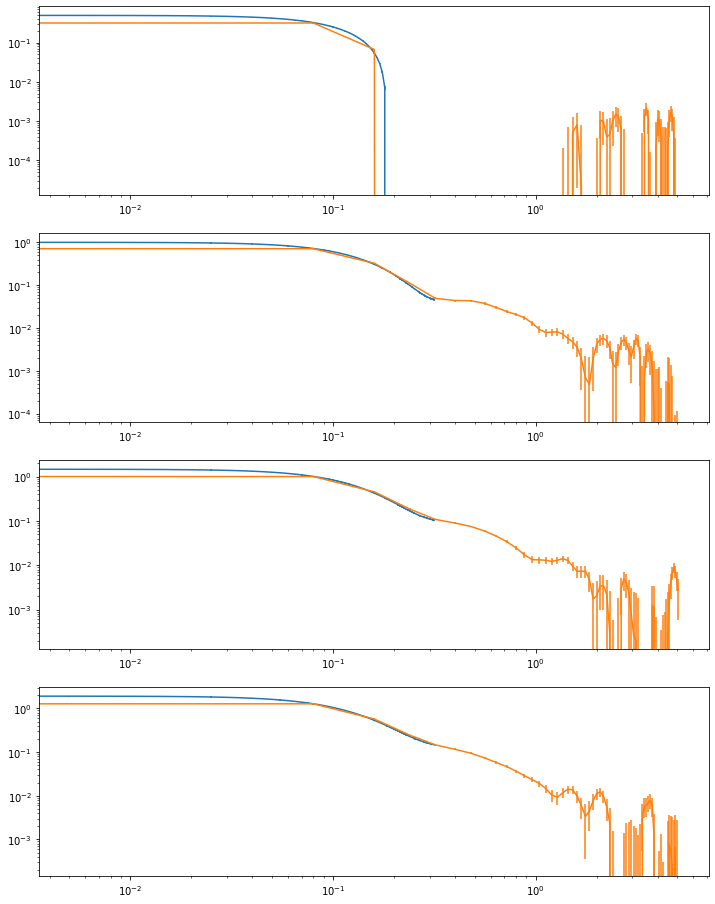

In [14]:
average_data_dict = {}  # Set up Dictionaries to store results
gav_dict = {}  #
box_dict = {}  #
vcorrav_dict = {}  #
av_dict = {}  #

# g_borges_dict = {}
g_borges_hist_dict = {}
# s_planes_dict = {}


nvariables_avg_data = 11

# quick figure for ACF
fig, axs = plt.subplots(nrows=nstate, figsize=(12, 16))
# for i, ax in enumerate(fig.axes):
#

print(f"The program will run simulations for {nstate} thermodynamic states")
for istate in range(nstate):
    print(f"Running simulation for current state= {istate+1}")

    avg_data = np.zeros((int(nstep / nsamp), nvariables_avg_data))
    av = np.zeros(6)
    veav = 0
    keav = 0
    teav = 0
    pav = 0
    nav = 0
    istep = 0
    gav = np.zeros(nbins)
    # s_sum = np.zeros(nbins // 2 + 1)

    borges0 = np.zeros([nstep // nsamp, nbins])
    borges1 = np.zeros([nstep // nsamp, nbins])

    ikeav = 0  # Inverse kinetic energy averaged

    #### for O(N)
    nsamplescg = np.zeros(nlevel, dtype=int)  # edit 18-03-2022
    ic = np.zeros(nlevel, dtype=int)
    vxs = np.zeros((nlevel, ncorrtot, npart))
    vys = np.zeros((nlevel, ncorrtot, npart))
    vzs = np.zeros((nlevel, ncorrtot, npart))
    vcorrav = np.zeros((nlevel, ncorrtot))
    vcorrav2 = np.zeros((nlevel, ncorrtot))
    #####################

    run_rhos = rhos  # [istate]
    run_temps = temps[istate]

    beta = 1 / run_temps

    pi = np.pi

    # Set up initial conditions

    boxs, cells, x, y, z, vx, vy, vz = lattice(npart, run_rhos, run_temps, ncell)

    box_dict[istate] = boxs

    # Compute initial potential energy and forces

    venergy, vir, fx, fy, fz = calc_energy_forces(npart, rc2, boxs, x, y, z)

    # Compute initial kinetic energy

    kenergy = 0
    for iparticle in range(npart):
        kenergy += 0.5 * (vx[iparticle] ** 2 + vy[iparticle] ** 2 + vz[iparticle] ** 2)

    # Equilibration loop

    for istep in range(nestep):
        x, y, z, vx, vy, vz, fx, fy, fz, venergy, kenergy, vir = vv_integrate(
            npart, boxs, x, y, z, vx, vy, vz, fx, fy, fz
        )
        if istep % nrescale:
            vx, vy, vz = rescalev(npart, run_temps, vx, vy, vz)

    # start of main time integration loop
    for istep in range(nstep):
        x, y, z, vx, vy, vz, fx, fy, fz, venergy, kenergy, vir = vv_integrate(
            npart, boxs, x, y, z, vx, vy, vz, fx, fy, fz
        )
        time = istep * dt

        ic, nsamplescg, vxs, vys, vzs, vcorrav, vcorrav2 = vcorrelate(
            istep, npart, vcorrav, vcorrav2, ic, nsamplescg, vxs, vys, vzs, vx, vy, vz
        )

        if istep != 0:
            if istep % nsamp == 0:
                hist = np.zeros(nbins)
                hist = calc_hist(npart, boxs, nbins, x, y, z, hist)
                b0, b1 = radial_borgis_bins(
                    nbins, npart, boxs, run_rhos, run_temps, x, y, z, fx, fy, fz
                )
                borges0[nav], borges1[nav] = b0, b1

                nav += 1
                # structure = structure_factor_from_planes(
                #    nbins, boxs, x, y, z, 2 * np.pi
                # )
                # s_sum += structure

                veav += venergy
                keav += kenergy
                teav += venergy + kenergy

                ikeav += 1 / kenergy

                pressv = 0.5 * vir / boxs**2
                pressi = run_rhos * run_temps
                pav += pressi + pressv
                gav += hist

                nslot = int(istep / nsamp)
                avg_data[nslot][0] = time

                avg_data[nslot][1] = venergy / npart
                avg_data[nslot][2] = kenergy / npart
                avg_data[nslot][3] = (venergy + kenergy) / npart

                avg_data[nslot][4] = veav / nav / npart
                avg_data[nslot][5] = keav / nav / npart
                avg_data[nslot][6] = teav / nav / npart

                avg_data[nslot][7] = pressi + pressv
                avg_data[nslot][8] = pav / nav
                avg_data[nslot][9] = pressi

                avg_data[nslot][10] = ikeav / (nav * npart)

            if istep % nreport == 0:
                print(f"At istep= {istep}, time is: {time}")
                print(
                    f" V/N = {venergy/npart}, K/N = {kenergy/npart}, E/N ={(venergy+kenergy)/npart}"
                )

    # Velocity correlation function
    v_corr = np.zeros((ncorrtot, 2 * nlevel))

    sumvcorr = 0.0

    ttt = np.zeros((ncorrtot))
    cvv = np.zeros((ncorrtot))
    cvv2 = np.zeros((ncorrtot))

    t_scale = np.zeros((nlevel, ncorrtot))
    levelmax = 0
    intstart = 0
    sumvcorr = 0.0
    ofree = 0.0
    for level in range(nlevel):
        if nsamplescg[level] >= 1:
            print(f"nsamplescg({level}) = {nsamplescg[level]}")
            ofree = 1.0 / math.sqrt(3.0 * npart * nsamplescg[level] - 1.0)
            levelmax = level
            vcorrav[level, :] = vcorrav[level, :] / (
                3.0 * npart * nsamplescg[level]
            )  # assuming three dimensions
            vcorrav2[level, :] = vcorrav2[level, :] / (
                3.0 * npart * nsamplescg[level]
            ) - np.square(vcorrav[level, :])
            vcorrav2[level, :] = np.sqrt(vcorrav2[level, :]) * ofree
            dtn = dt * ncorr ** (level)
            for n in range(ncorrtot):
                t_scale[level, n] = n * dtn
                ttt[n] = n * dtn
                cvv[n] = vcorrav[level, n]
                cvv2[n] = vcorrav2[level, n]
                if n >= intstart:
                    sumvcorr += vcorrav[level, n] * dtn
                    if n == intstart:
                        sumvcorr -= (
                            0.5 * vcorrav[level, n] * dtn
                        )  # remove one half of the first integraton point
                v_corr[n, 2 * level] = n * dtn
                v_corr[n, 2 * level + 1] = vcorrav[level, n]
            intstart = int(ncorrtot / ncorr)
        #   quick plot
        if level <= levelmax:
            #            plt.semilogx(ttt, cvv)
            axs[istate].errorbar(ttt, cvv, yerr=cvv2)
            # plt.axhline(color="gray", zorder=-2)
            # plt.axvline(color="gray", zorder=-2)
            axs[istate].set_xscale("log")
            axs[istate].set_yscale("log")
            # plt.xscale('log')
            # plt.yscale('log')
            # plt.show()
    #   end quick plot

    vav = veav / (nav * npart)
    kav = keav / (nav * npart)
    tav = teav / (nav * npart)

    ikeav /= nav * npart

    d_v = sumvcorr * 2.0 * kenergy / (float(dimens * npart) * vcorrav[0, 0])
    av[0] = run_rhos
    av[1] = d_v
    #    av[2]=d_r
    av[3] = vav
    av[4] = kav
    av[5] = tav

    print(f"At istep= {istep}, time is: {time}")
    print(
        f" V/N = {venergy/npart}, K/N = {kenergy/npart}, E/N ={(venergy+kenergy)/npart}"
    )

    print(f" ***Final average quantities***")
    print(f"D_v = {d_v}")
    print(f"<V>/N ={vav}, <K>/N ={kav}, <E>/N ={tav}")
    print(f" *********Run Complete*********")

    vcorrav_dict[istate] = v_corr
    average_data_dict[istate] = avg_data  #
    gav_dict[istate] = gav  #
    av_dict[istate] = av  #

    # s_planes_dict[istate] = [np.fft.rfftfreq(nbins, boxs / nbins) * 2 * pi, s_sum / nav]

    # r_borges, g_borges0, g_borges1 = radial_borgis(
    #    npart, boxs, run_rhos, temps, x, y, z, fx, fy, fz
    # )

    # g_borges_dict[istate] = [r_borges, g_borges0, g_borges1]

    g_borges_hist_dict[istate] = [borges0, borges1]

# Show quick ACF-plot
plt.show()

# (4) Analyzing the data

## (4.1) Processing g(r) data

In [15]:
g_r_dict = {}  # Uncomment to setup g(r) data save dictionary for given Temp

for istate in range(nstate):

    gav = gav_dict[istate]  # Uncomment to read g(r) data dictionary for given Temp
    L = box_dict[istate]

    rmax = 0.5 * L
    dr = rmax / nbins

    g_r = np.zeros((nbins, 2))  # Change name of this structure for each new run

    for n in range(1, nbins):
        r = n * dr
        g_r[n, 0] = r  # Same here
        g_r[n, 1] = (
            (gav[n] / nav) / (4 * 3.14159265 * rhos * r**2 * dr) * 2 / npart
        )  # Same here

    g_r_dict[istate] = g_r  # Uncomment to save g(r) data dictionary for given Temp

## (4.2) Plotting the run history data

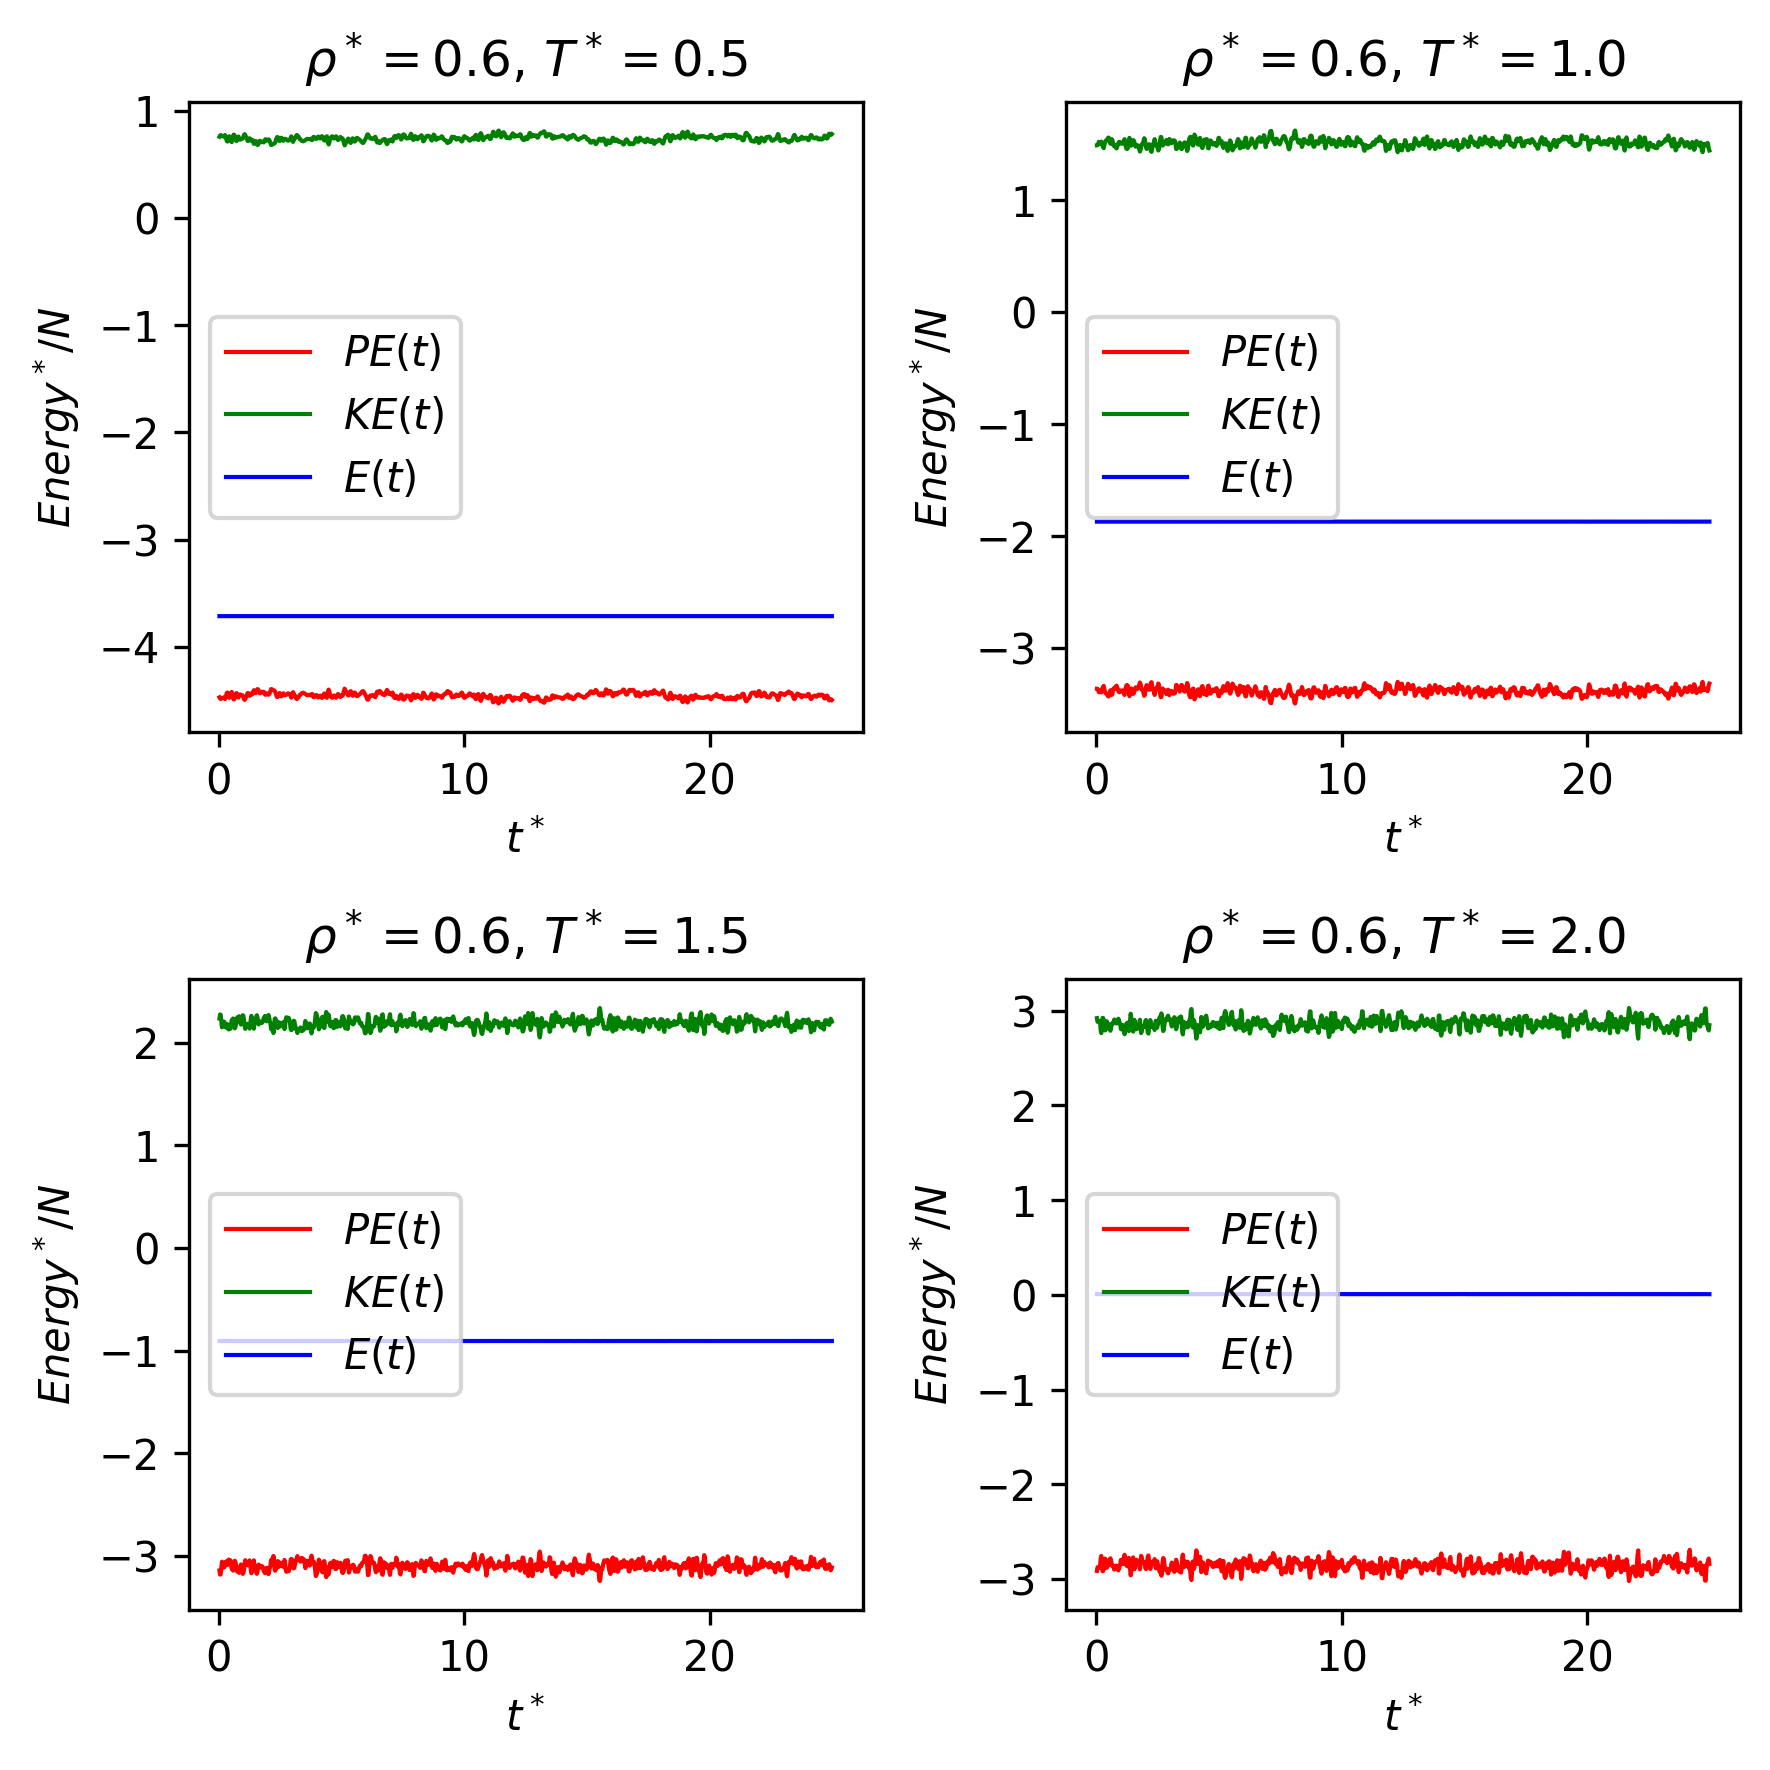

In [16]:
fig, axes = plt.subplots(
    figsize=(6, 3 * max(1, nstate // 2)), dpi=300, ncols=2, nrows=max(1, nstate // 2)
)

for irun, axi in enumerate(fig.axes):
    if irun >= nstate:
        axi.axis("off")
        break
    # axi.set_xlim(0,nmov)
    axi.set_xlabel(r"$t^*$")

    # axi.set_ylim(-5.5, 2.0)
    axi.set_ylabel(r"$Energy^* / N$")

    # axi.tick_params(axis="both", labelsize=18)

    axi.set_title(
        r"$\rho^*=$" + f"{rhos}, " + r"$T^*=$" + f"{temps[irun]}"
    )  # Uncomment to provide Temp labels

    axi.plot(
        average_data_dict[irun][1:, 0],
        average_data_dict[irun][1:, 1],
        lw=1.0,
        c="r",
        label=r"$PE(t)$",
    )  # Add lines with different data structure names for each run here
    axi.plot(
        average_data_dict[irun][1:, 0],
        average_data_dict[irun][1:, 2],
        lw=1.0,
        c="g",
        label=r"$KE(t)$",
    )  # Add lines with different data structure names for each run here
    axi.plot(
        average_data_dict[irun][1:, 0],
        average_data_dict[irun][1:, 3],
        lw=1.0,
        c="b",
        label=r"$E(t)$",
    )  # Add lines with different data structure names for each run here

    axi.legend(loc="center left")

fig.tight_layout()

## Plot pressure

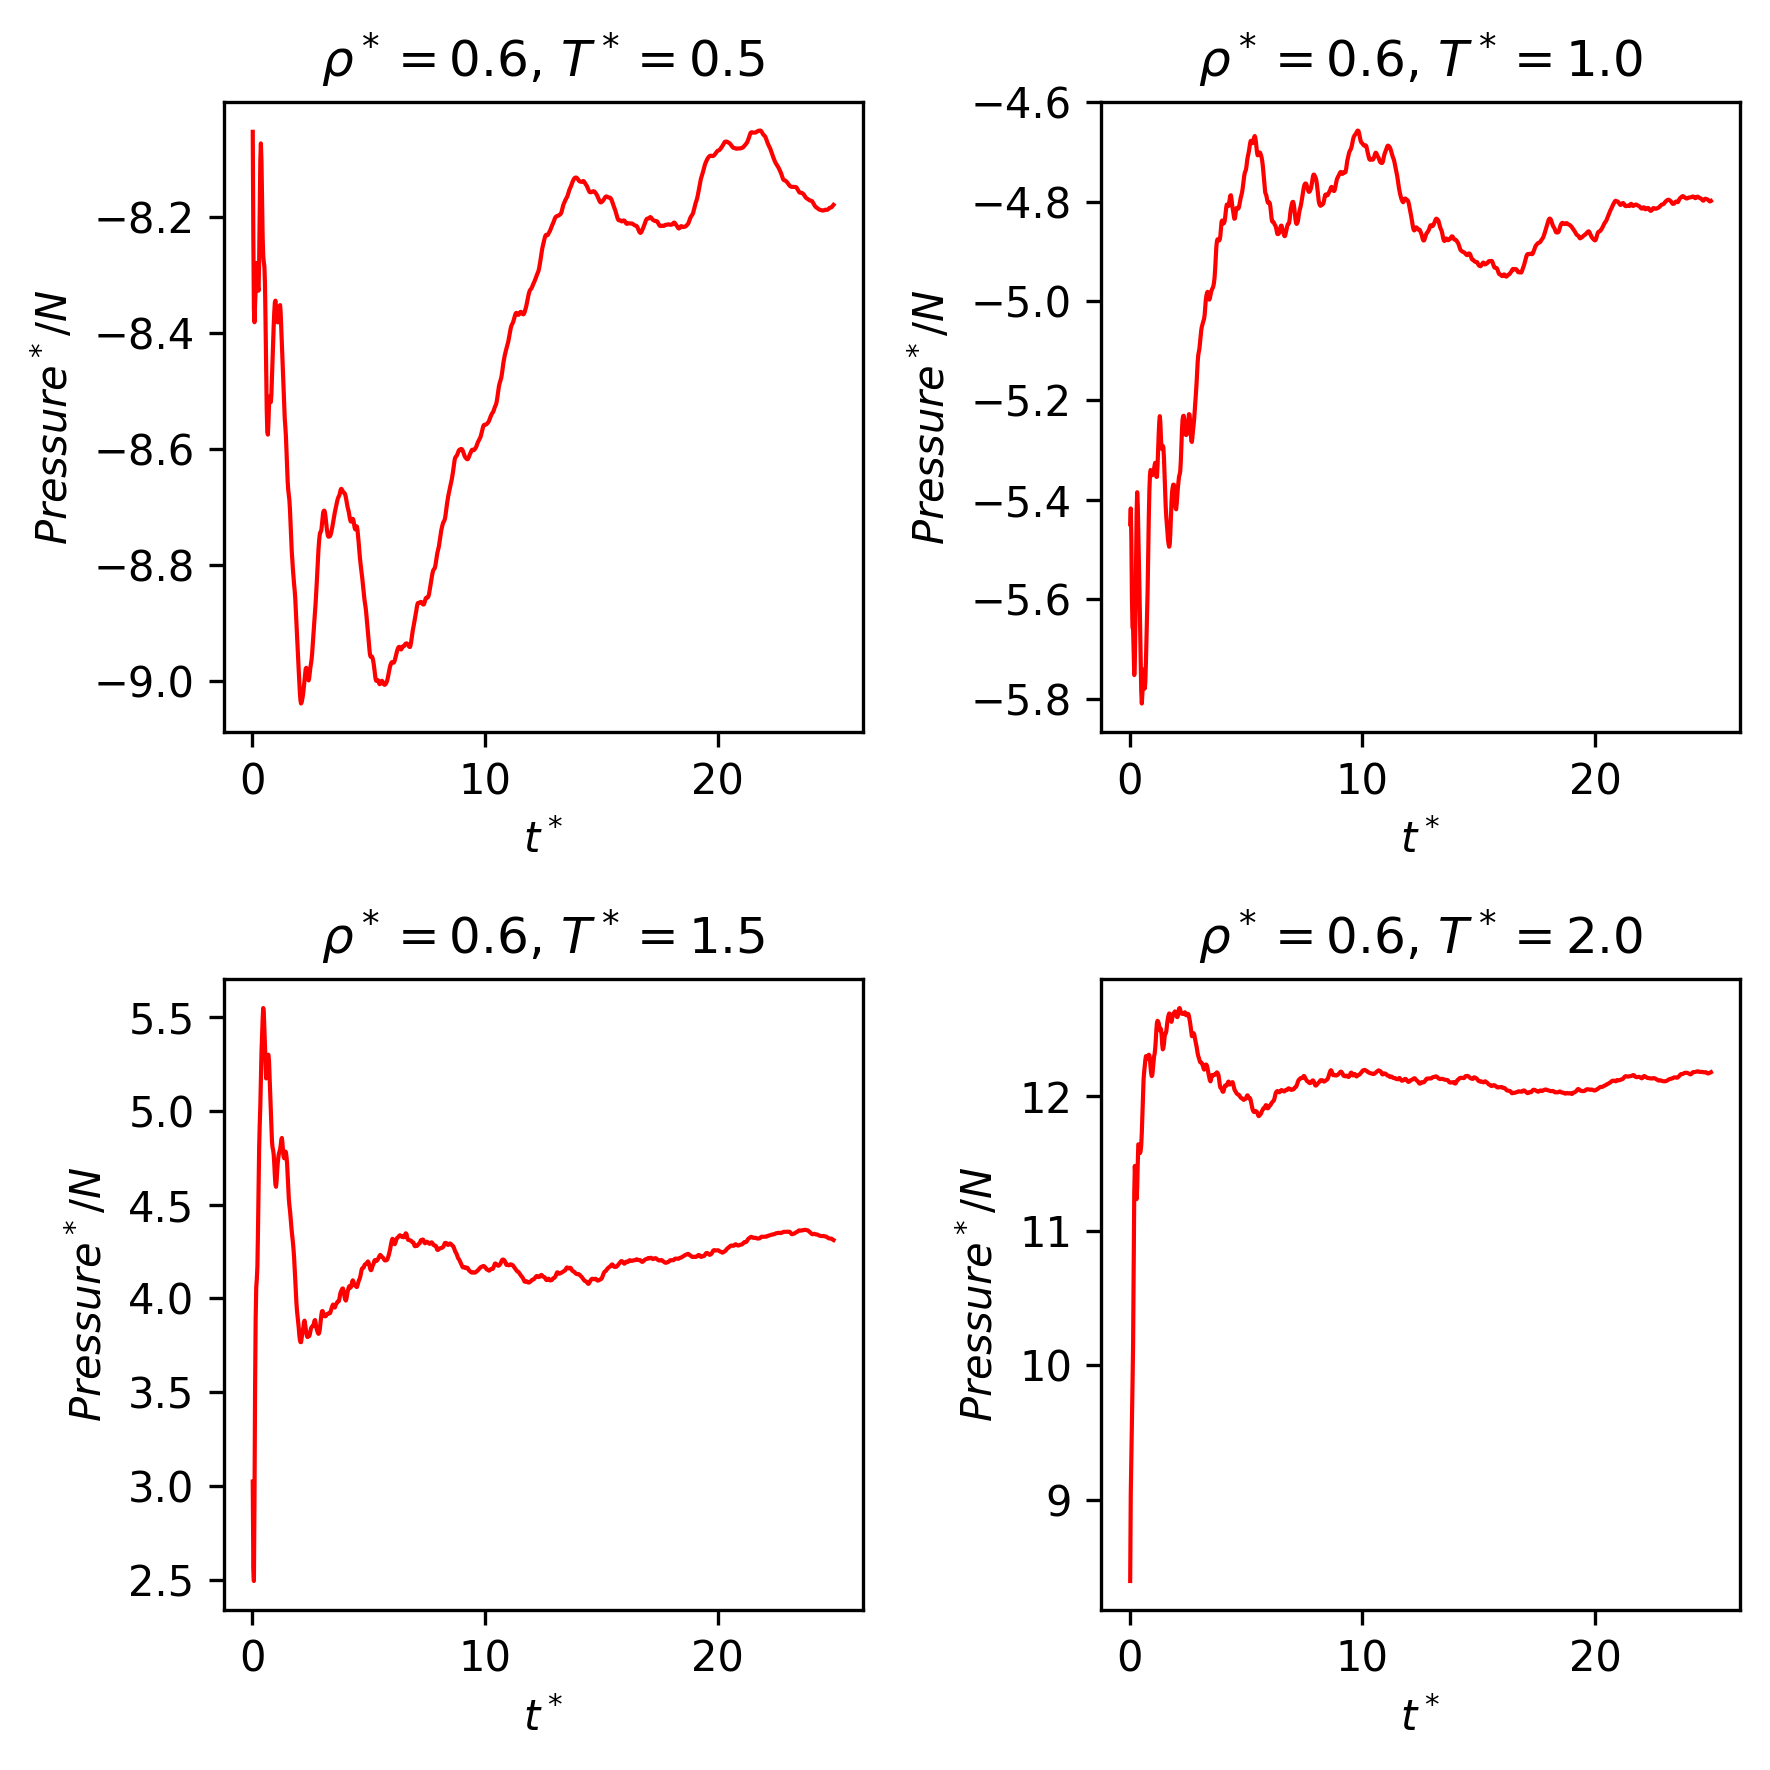

In [17]:
# fig, ax = plt.subplots(figsize=(7, 3 * nstate), dpi=300, nrows=nstate)
fig, axs = plt.subplots(
    figsize=(6, 3 * max(1, nstate // 2)), dpi=300, ncols=2, nrows=max(1, nstate // 2)
)
for istate, axi in enumerate(fig.axes):
    axi.plot(
        average_data_dict[istate][1:, 0],
        average_data_dict[istate][1:, 8],
        lw=1.0,
        c="r",
        label=r"$P(t)$",
    )
    axi.set_title(r"$\rho^*=$" + f"{rhos}, " + r"$T^*=$" + f"{temps[istate]}")
    axi.set_xlabel(r"$t^*$")
    axi.set_ylabel(r"$Pressure^* / N$")
fig.tight_layout()

## Cv
$C_v^*=\left[ N-NT^* \left( \frac{3N}{2}-1\right) \langle E_k^{*-1}\rangle \right]^{-1}$

state 0 has C_v*=0.0020
state 1 has C_v*=0.0020
state 2 has C_v*=0.0020
state 3 has C_v*=0.0020


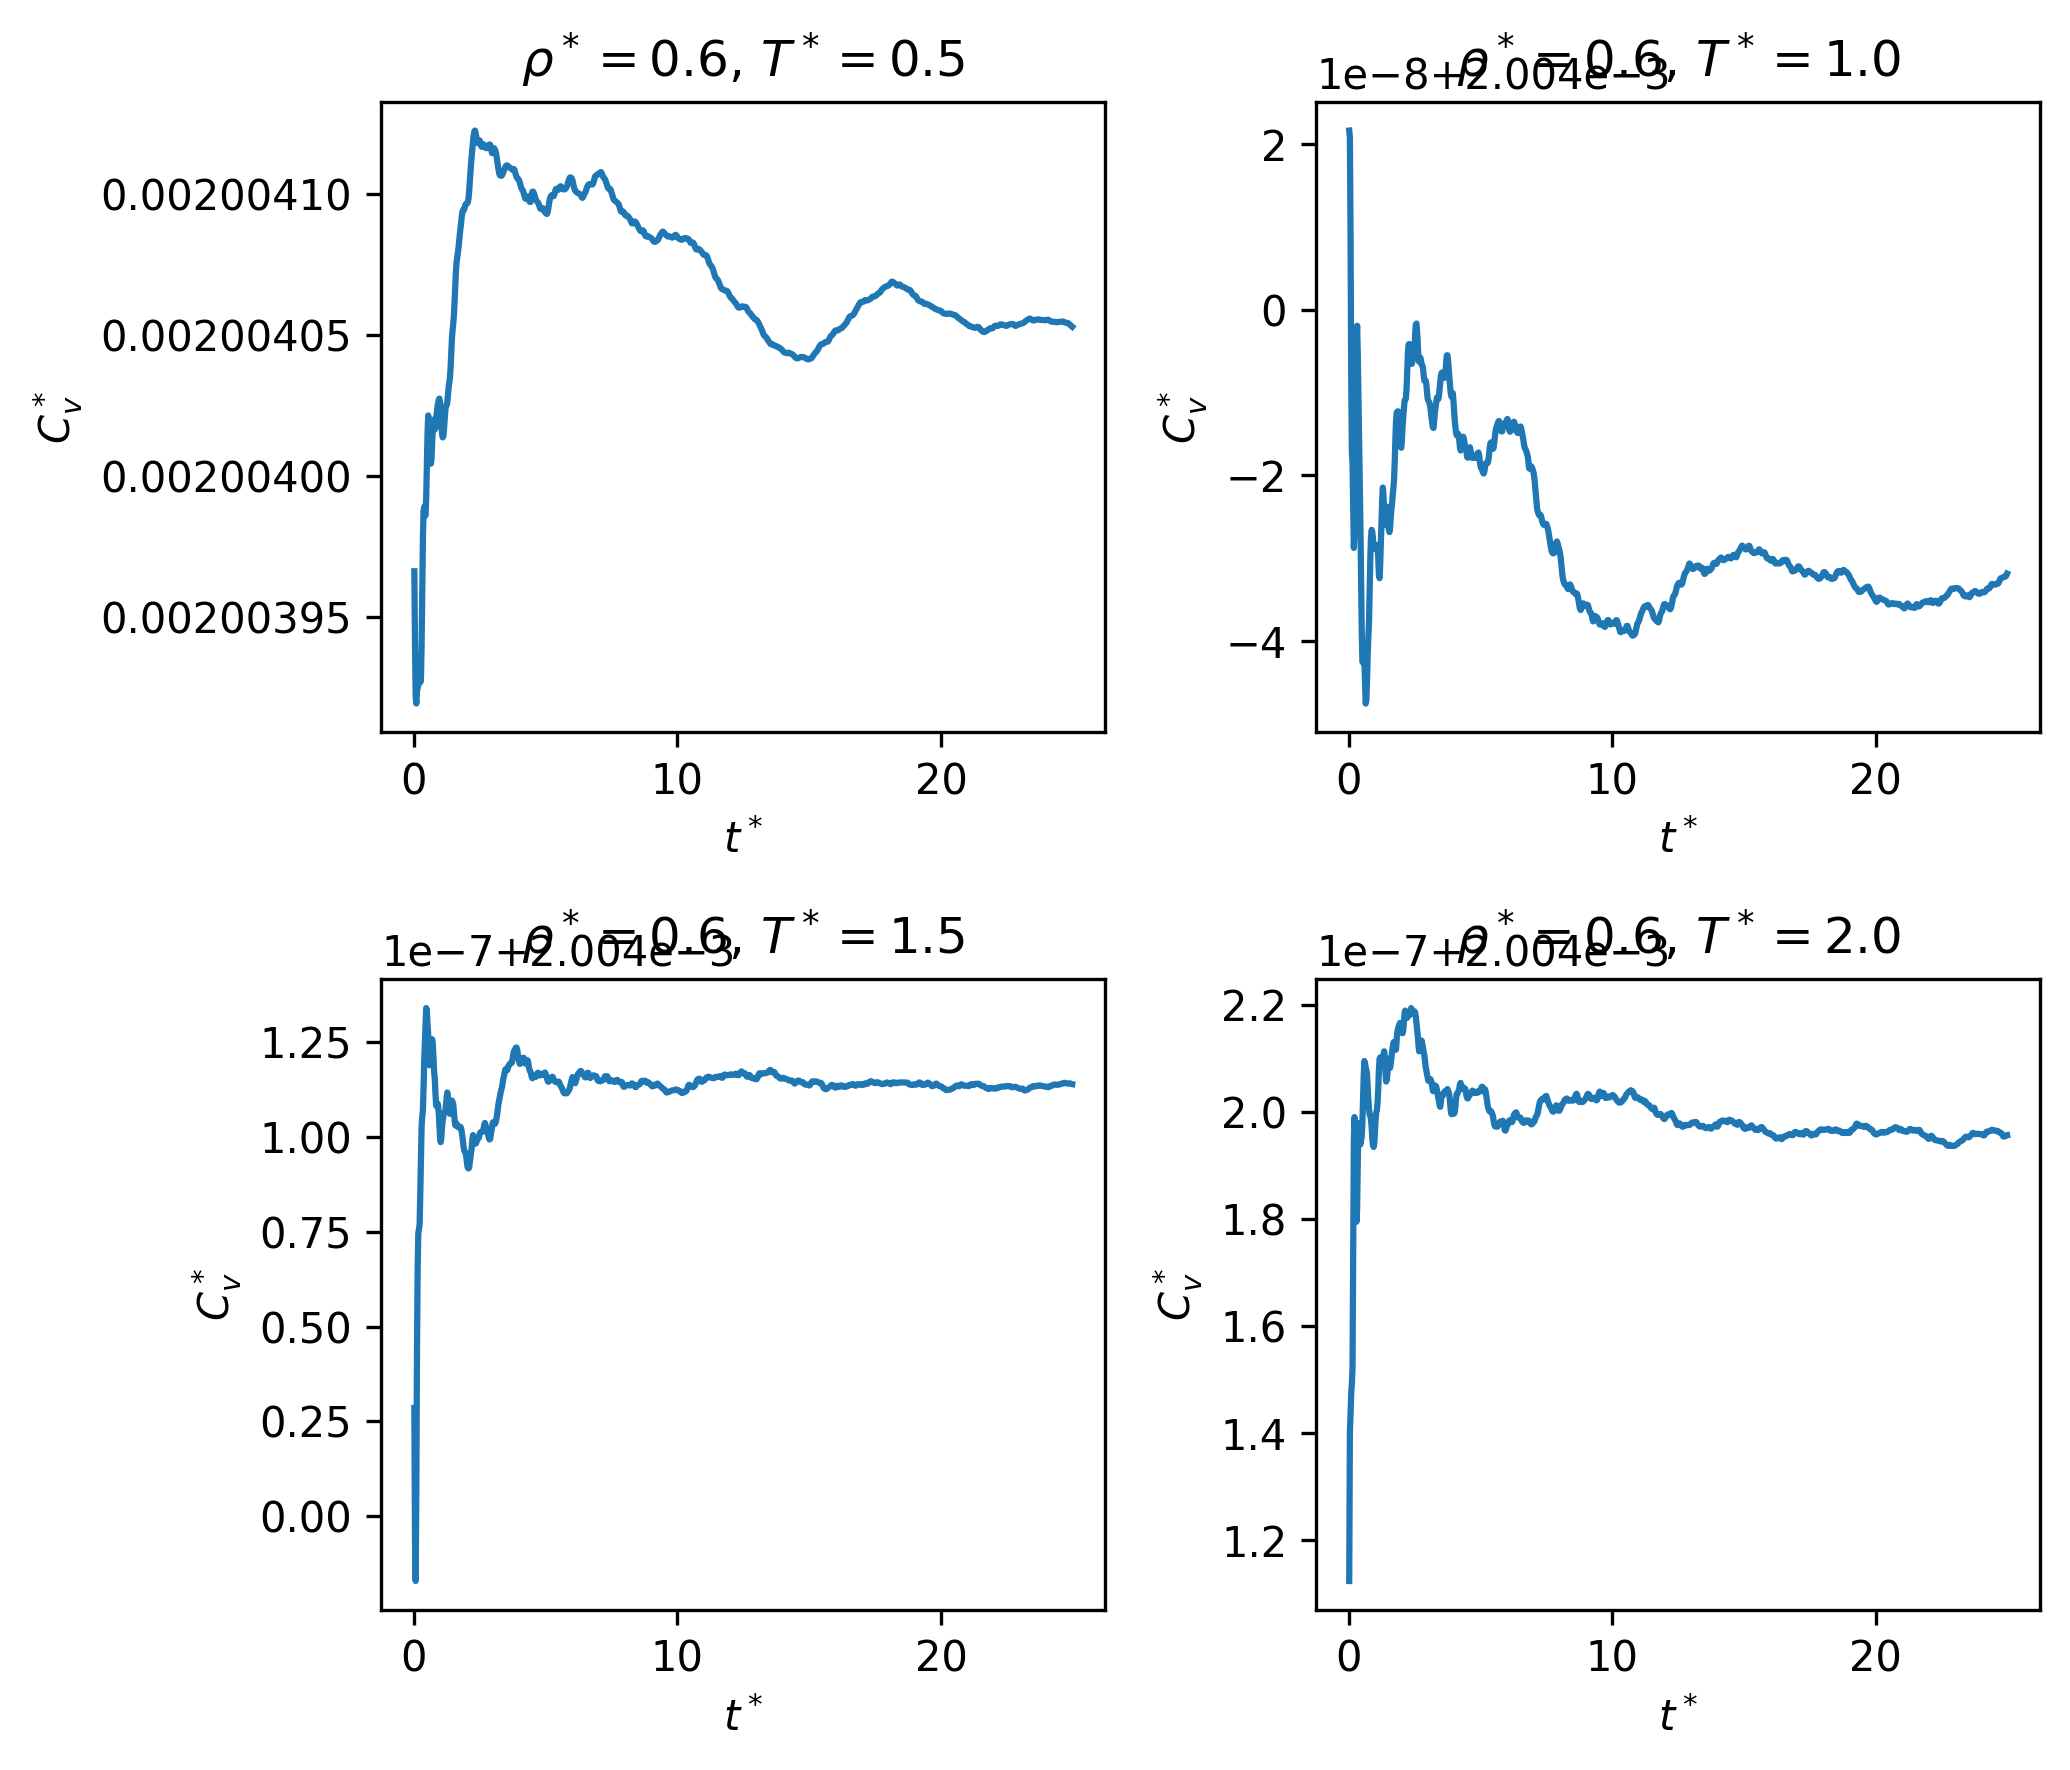

In [21]:
fig, axs = plt.subplots(
    figsize=(7, 3 * max(1, nstate // 2)), dpi=300, ncols=2, nrows=max(1, nstate // 2)
)

for istate, axi in enumerate(fig.axes):
    cv = 1.0 / (
        npart
        - npart
        * temps[istate]
        * (3 * npart / 2.0 - 1)
        * average_data_dict[istate][1:, 10]
    )
    axi.plot(average_data_dict[0][1:, 0], cv)
    axi.set_title(r"$\rho^*=$" + f"{rhos}, " + r"$T^*=$" + f"{temps[istate]}")
    axi.set_xlabel(r"$t^*$")
    axi.set_ylabel(r"$C_v^*$")
    print(f"state {istate} has C_v*={cv[-1]:.4f}")
plt.tight_layout()

## (4.3) Plots g(r)

/var/folders/m5/dyykzjj14d70s_k4cmn5n5_m0000gn/T/ipykernel_64805/3779523237.py:19: RuntimeWarning: invalid value encountered in double_scalars
  1 - np.cov(e1, delta)[0][1] ** 2 / (np.var(e1) * np.var(delta))


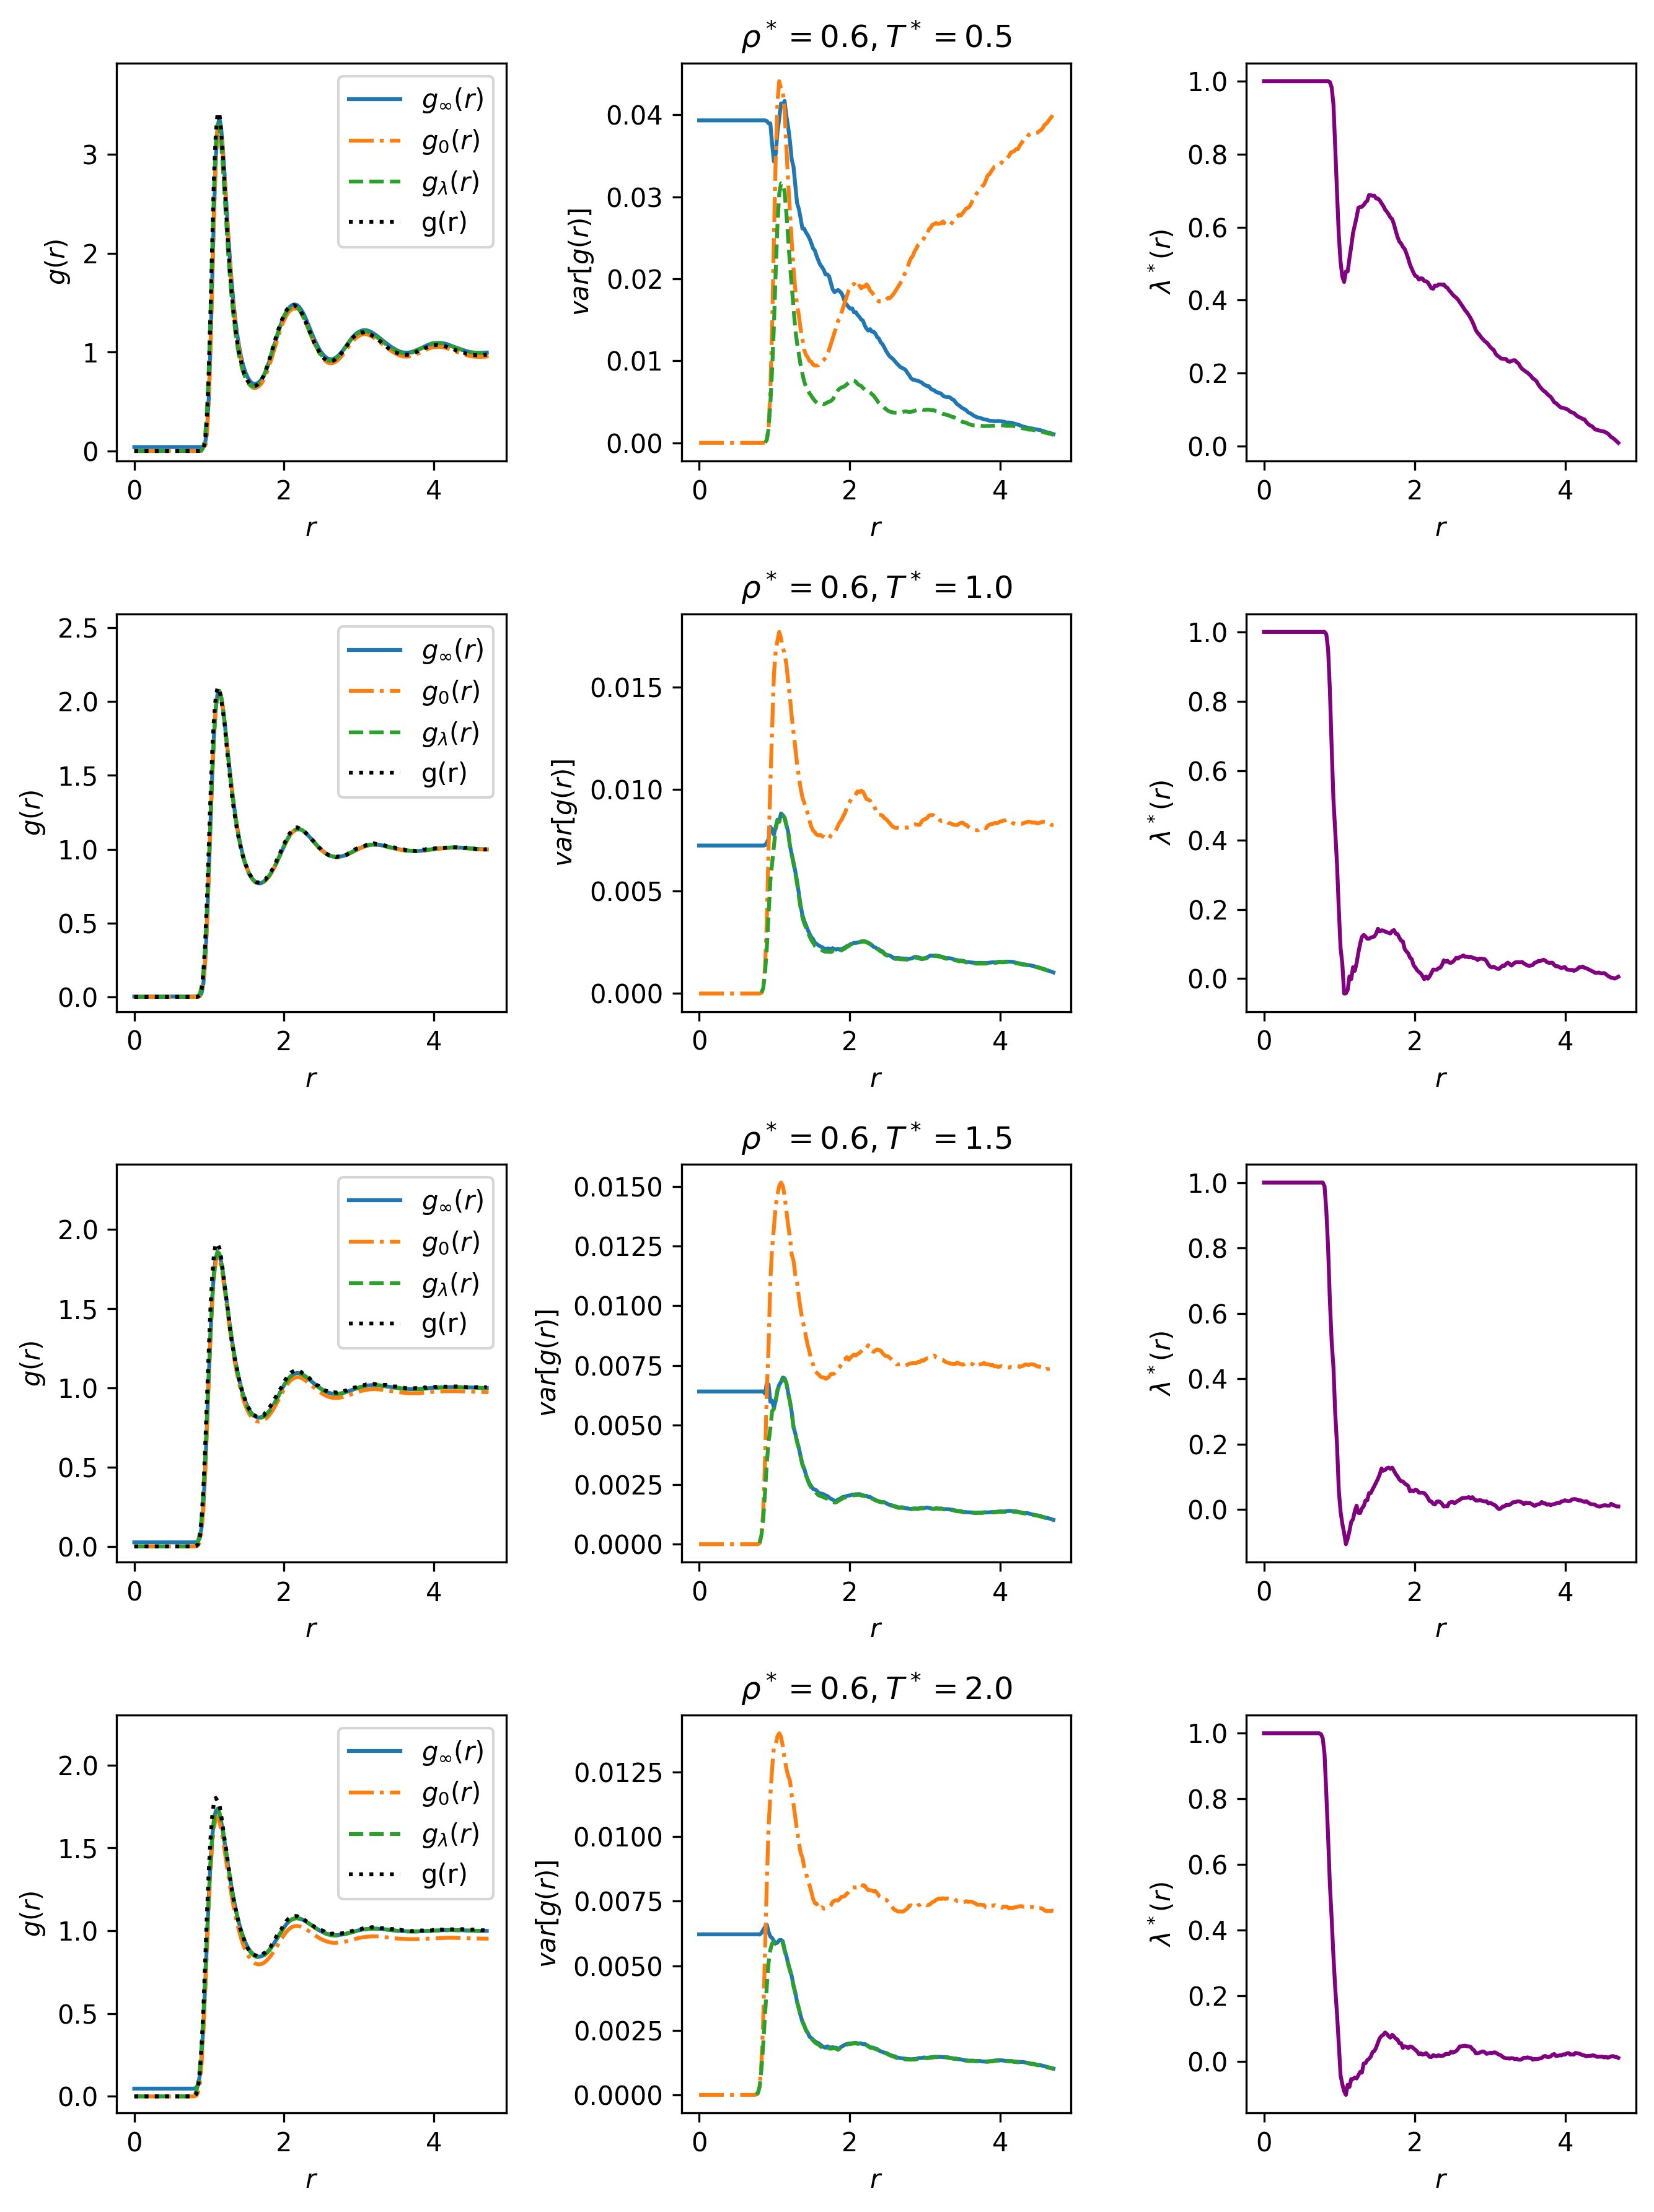

In [20]:
fig, ax = plt.subplots(ncols=3, nrows=nstate, figsize=(9, 3 * nstate), dpi=300)
axs = ax.flatten()

for istate in range(nstate):
    # print(npart, rhos[istate])
    b0, b1 = g_borges_hist_dict[istate]
    e_lambda = np.zeros(b0.shape[1])
    lambda_star = np.zeros(b0.shape[1])
    e_var = np.zeros(b0.shape[1])

    for i, (e0, e1) in enumerate(zip(b0.T, b1.T)):
        e0_mean = np.mean(e0)
        e1_mean = np.mean(e1)
        delta = e1 - e0
        delta_mean = e1_mean - e0_mean
        lambda_star[i] = 1 - np.cov(e1, delta)[0][1] / np.var(delta)
        e_lambda[i] = e0_mean + lambda_star[i] * delta_mean
        e_var[i] = (
            1 - np.cov(e1, delta)[0][1] ** 2 / (np.var(e1) * np.var(delta))
        ) * np.var(e1)

    r = np.linspace(0, 0.5 * boxs, nbins)

    # Loop over all cols in figure
    axi = axs[3 * istate + 0]

    axi.plot(r, np.mean(b0, axis=0), label=r"$g_{\infty}(r)$")
    axi.plot(r + r[1], np.mean(b1, axis=0), label=r"$g_{0}(r)$", ls="dashdot")
    axi.plot(r, e_lambda, label=r"$g_{\lambda}(r)$", ls="dashed")
    axi.set_ylabel(r"$g(r)$")
    axi.set_xlabel(r"$r$")
    axi.plot(
        r,
        g_r_dict[istate][:, 1],
        label="g(r)",
        ls="dotted",
        color="black",
    )
    # axi.legend(
    #    bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", mode="expand", ncol=2
    # )
    axi.set_ylim(-0.1, np.max(g_r_dict[istate][:, 1]) + 0.5)
    axi.legend(loc="upper right")

    axi = axs[3 * istate + 1]
    axi.plot(r, np.var(b0, axis=0))
    axi.plot(r, np.var(b1, axis=0), ls="dashdot")
    axi.plot(r, e_var, ls="dashed")
    axi.set_ylabel(r"$var[g(r)]$")
    axi.set_xlabel(r"$r$")
    axi.set_title(rf"$\rho^*={rhos}, T^*={temps[istate]}$")

    axi = axs[3 * istate + 2]
    axi.plot(r, lambda_star, color="purple")
    axi.set_ylabel(r"$\lambda^*(r)$")
    axi.set_xlabel(r"$r$")


plt.tight_layout()
# print(np.var(e#))

## (4.4) Plots of MSD(t) and VAC(t)

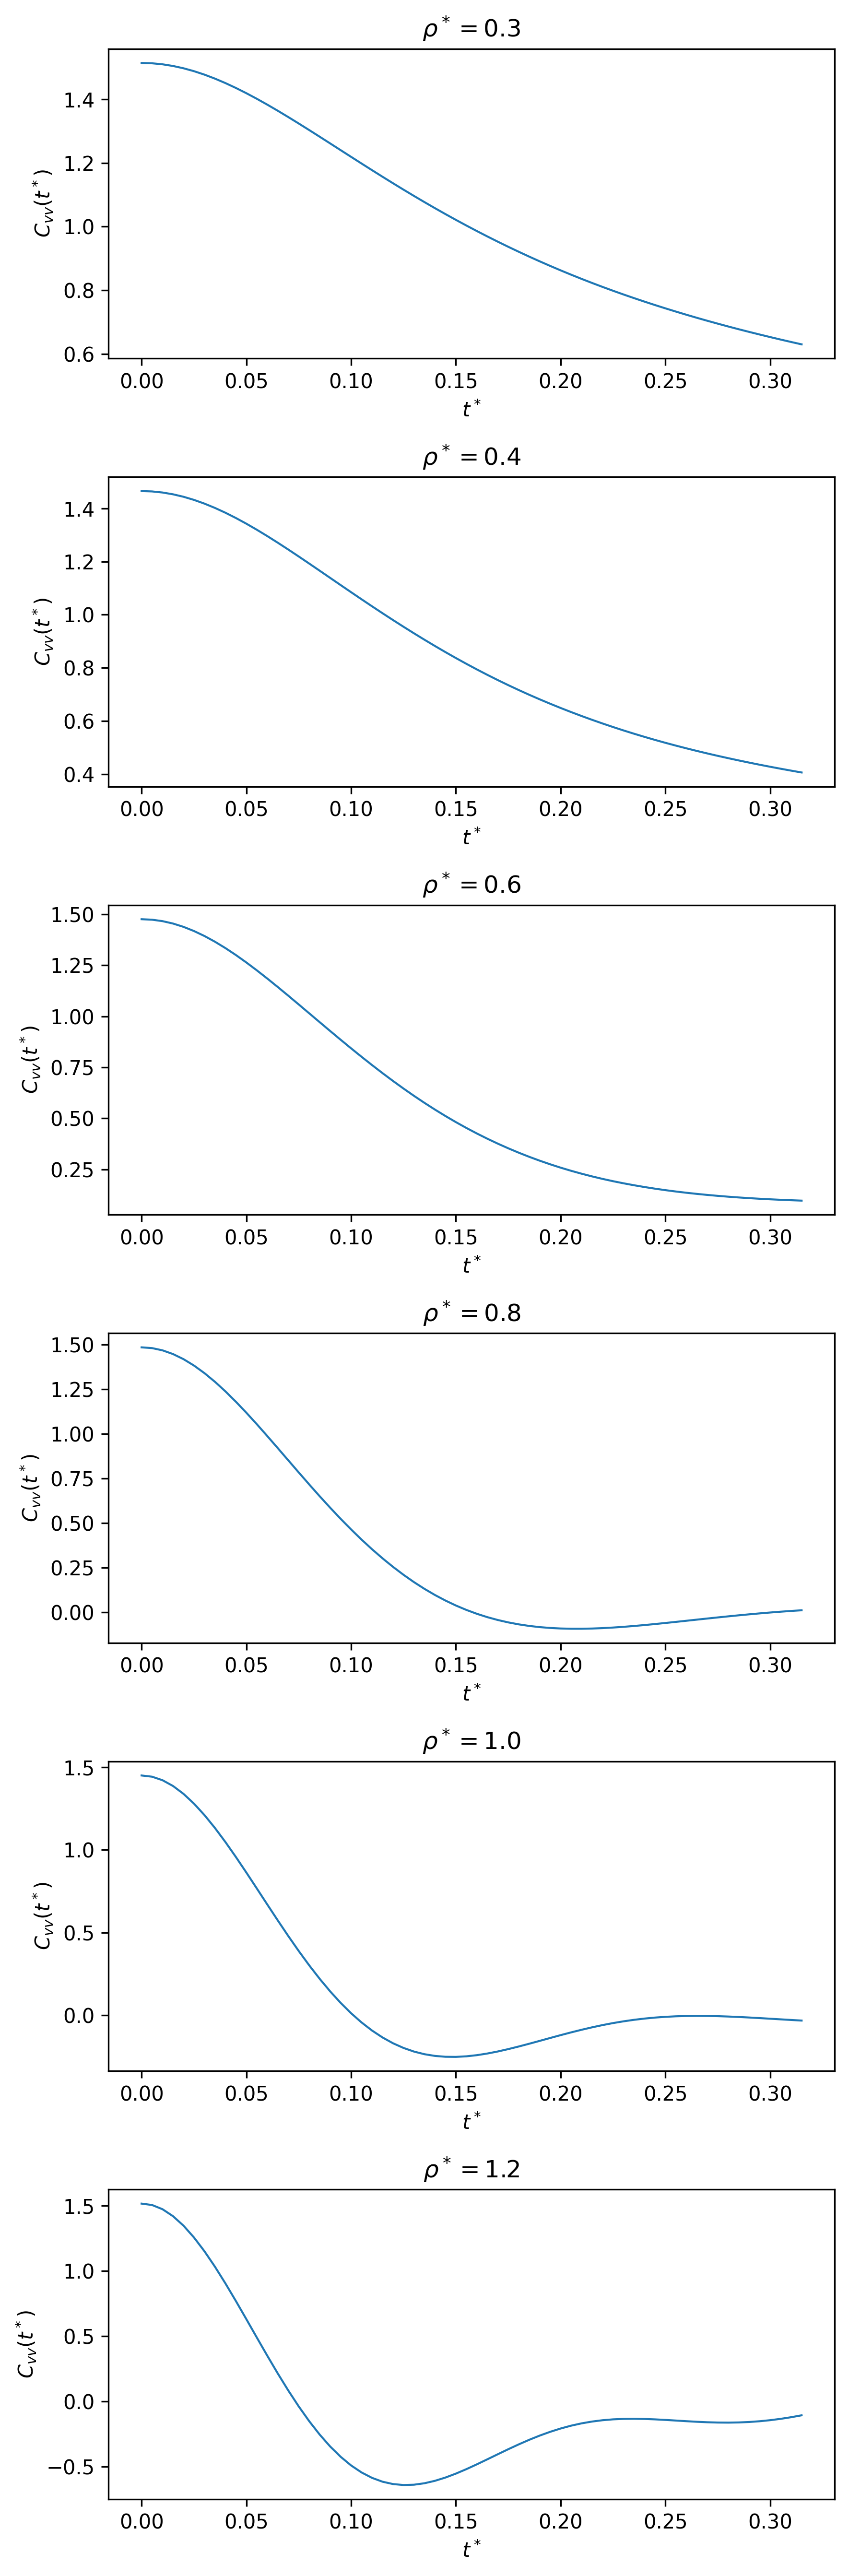

In [ ]:
fig, ax = plt.subplots(
    figsize=(6 * levelmax, 3 * nstate // levelmax),
    dpi=300,
    ncols=levelmax,
    nrows=nstate // levelmax,
)

axs = ax.flatten()

for istate in range(nstate):
    for level in range(levelmax):
        axi = axs[levelmax * istate + level]
        axi.set_title(r"$\rho^*=$" + f"{rhos[istate]}")
        axi.set_xlabel(r"$t^*$")
        axi.set_ylabel(r"$C_{vv}(t^*)$")
        axi.plot(
            vcorrav_dict[istate][:, 2 * level],
            vcorrav_dict[istate][:, 2 * level + 1],
            lw=1.0,
        )
plt.tight_layout()

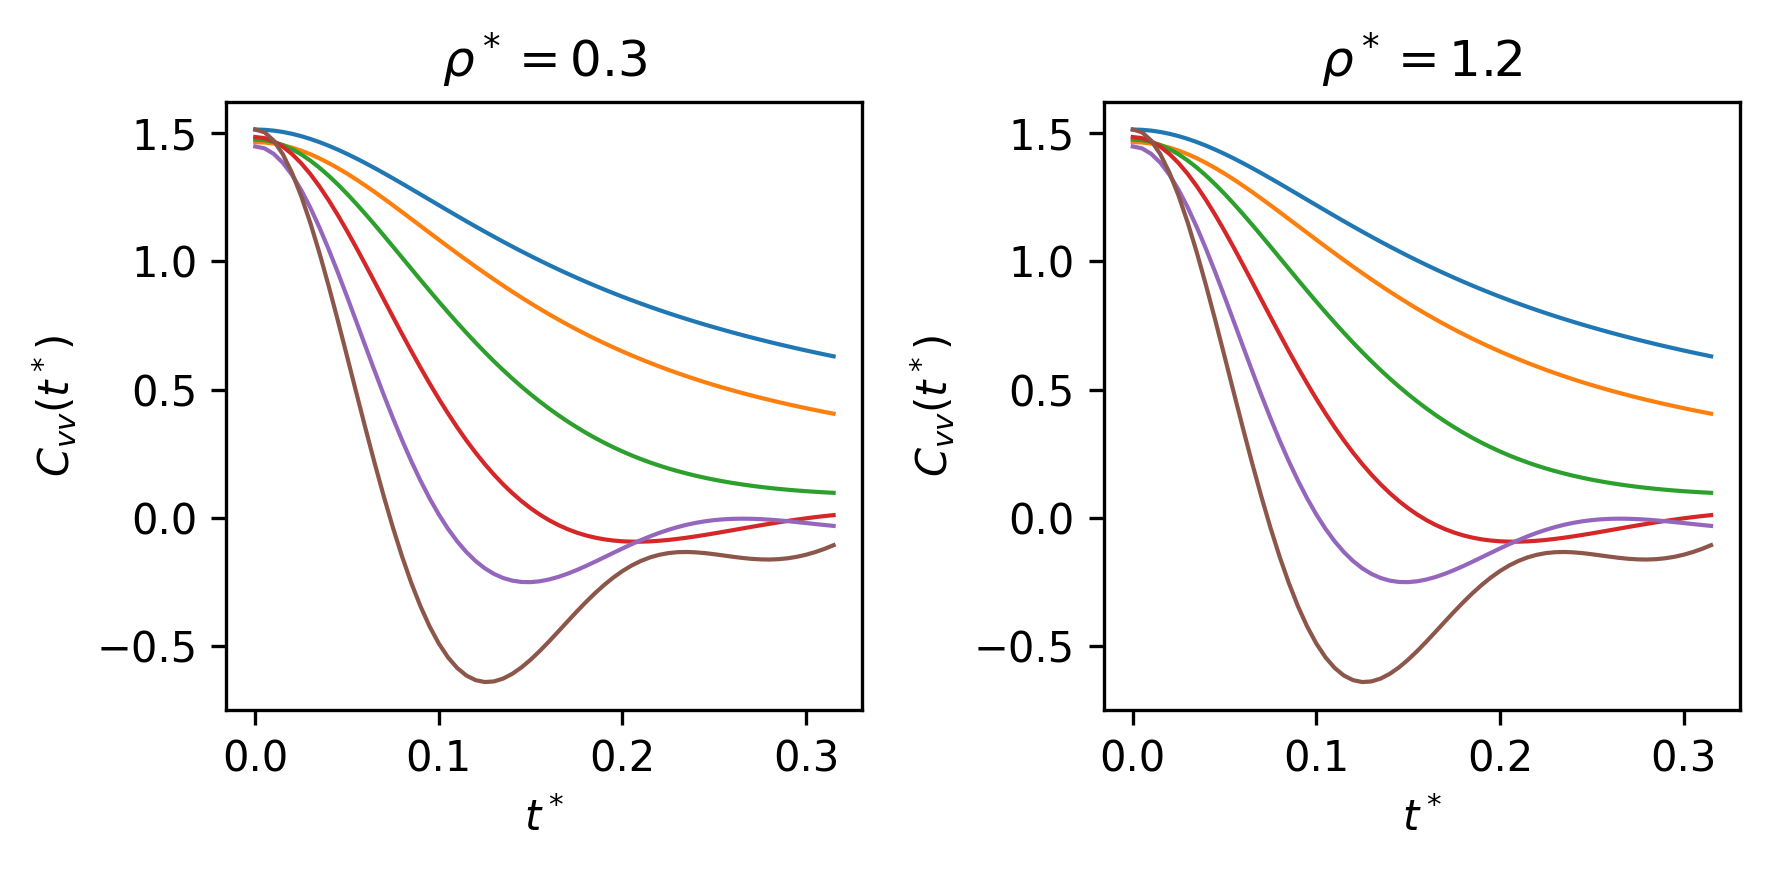

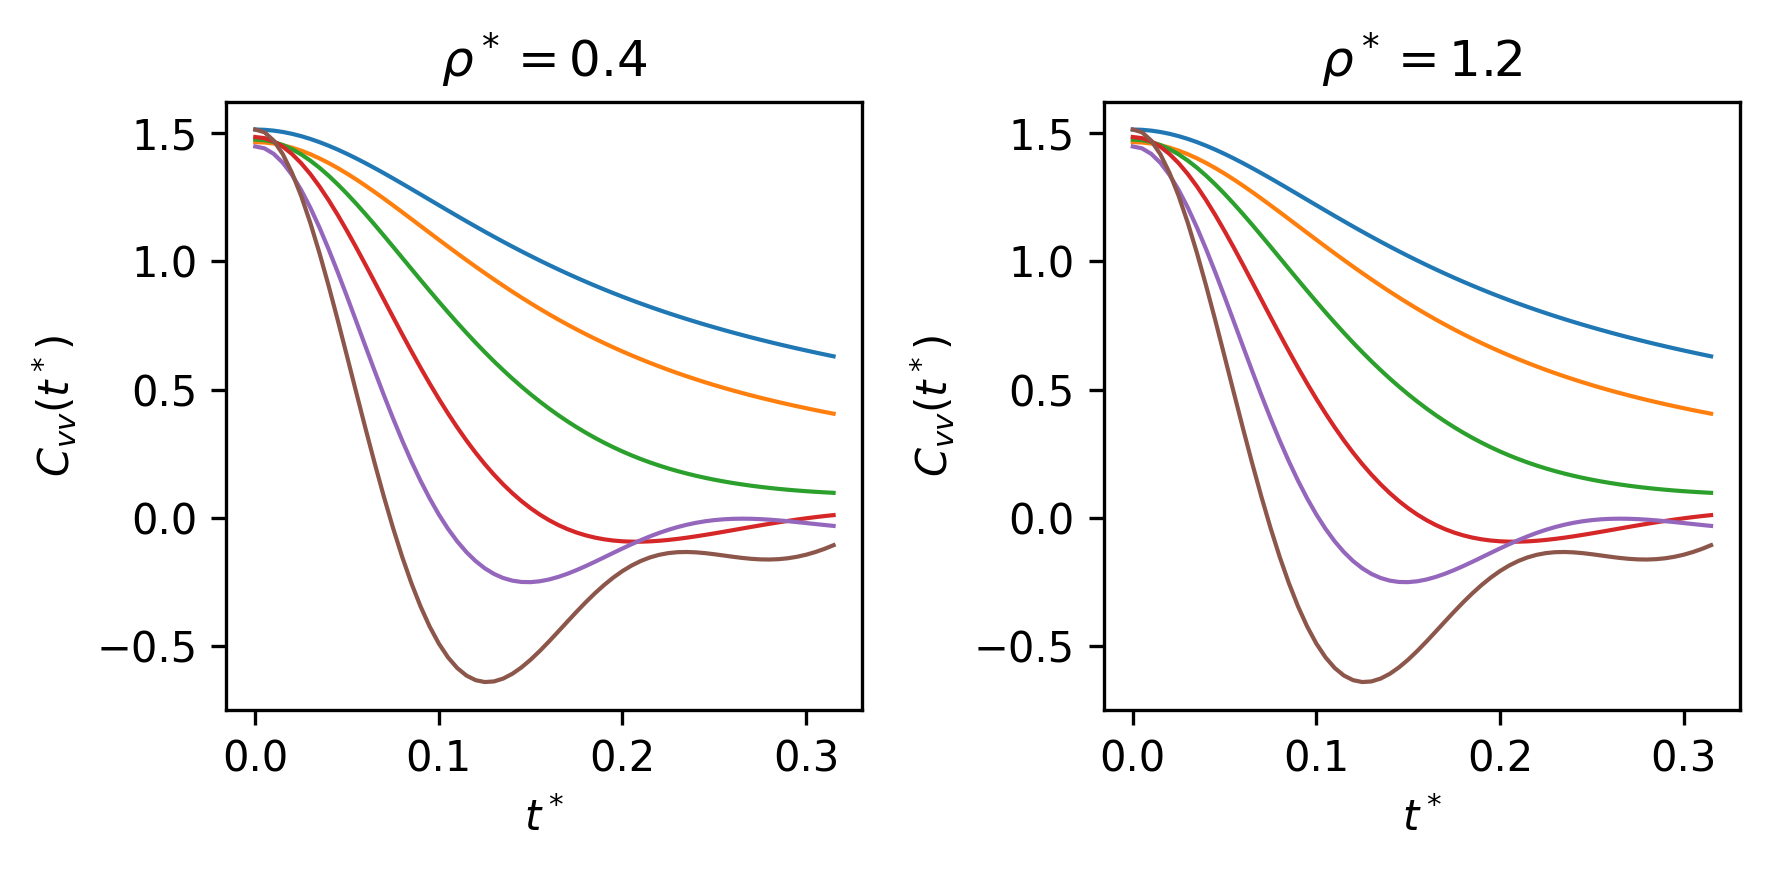

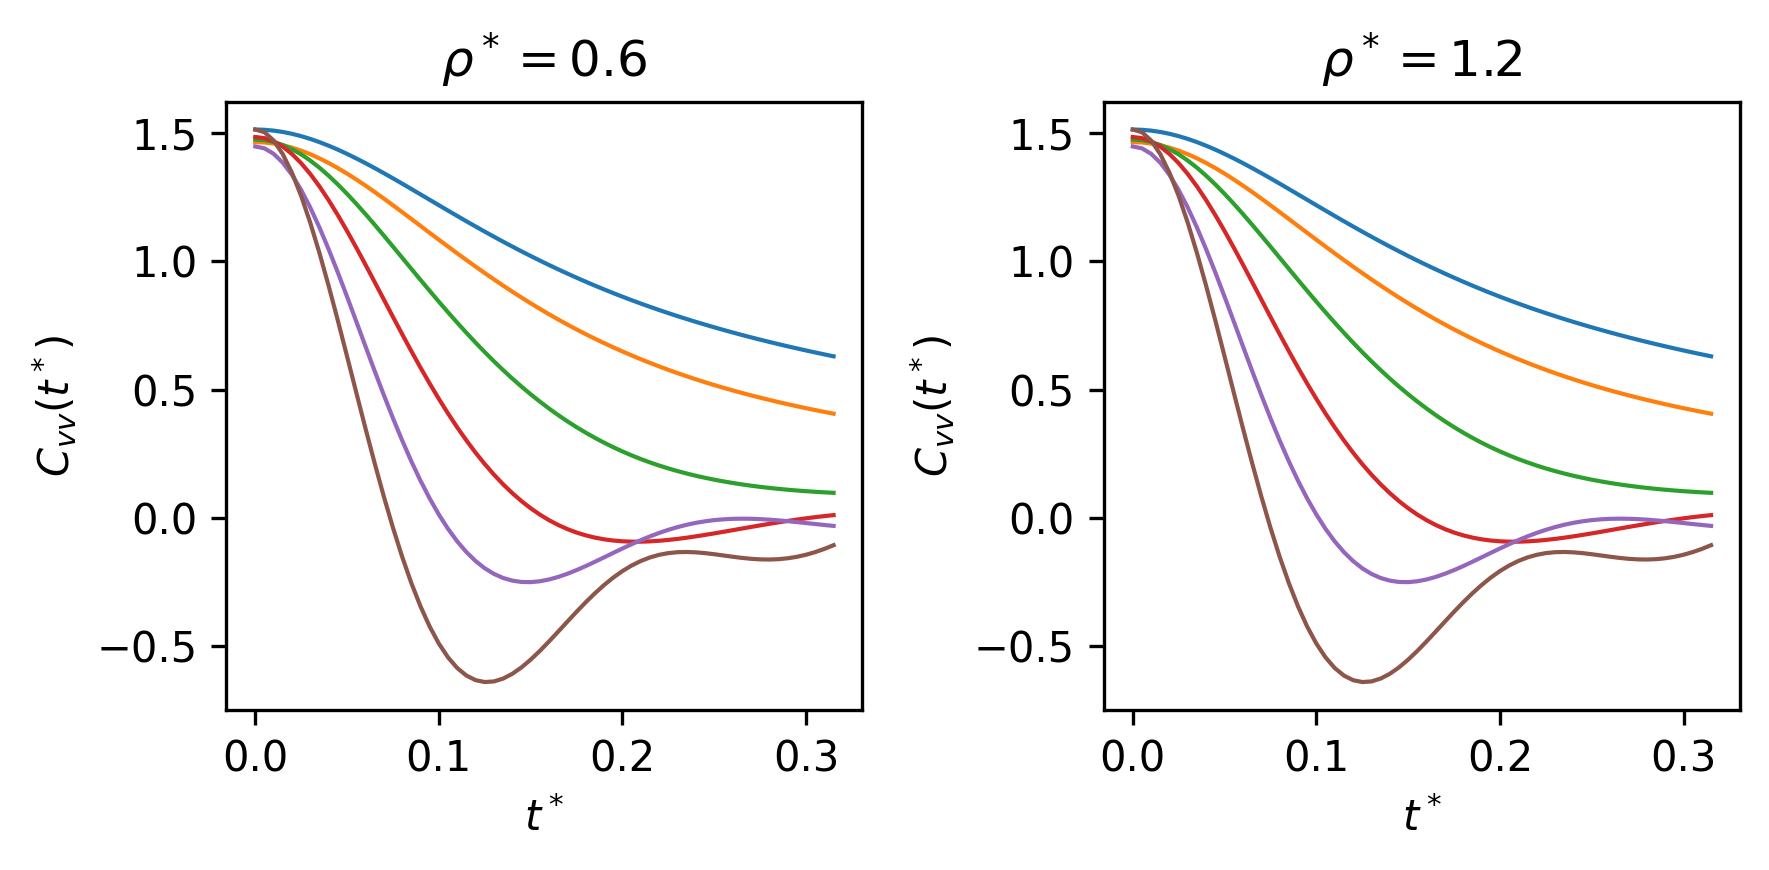

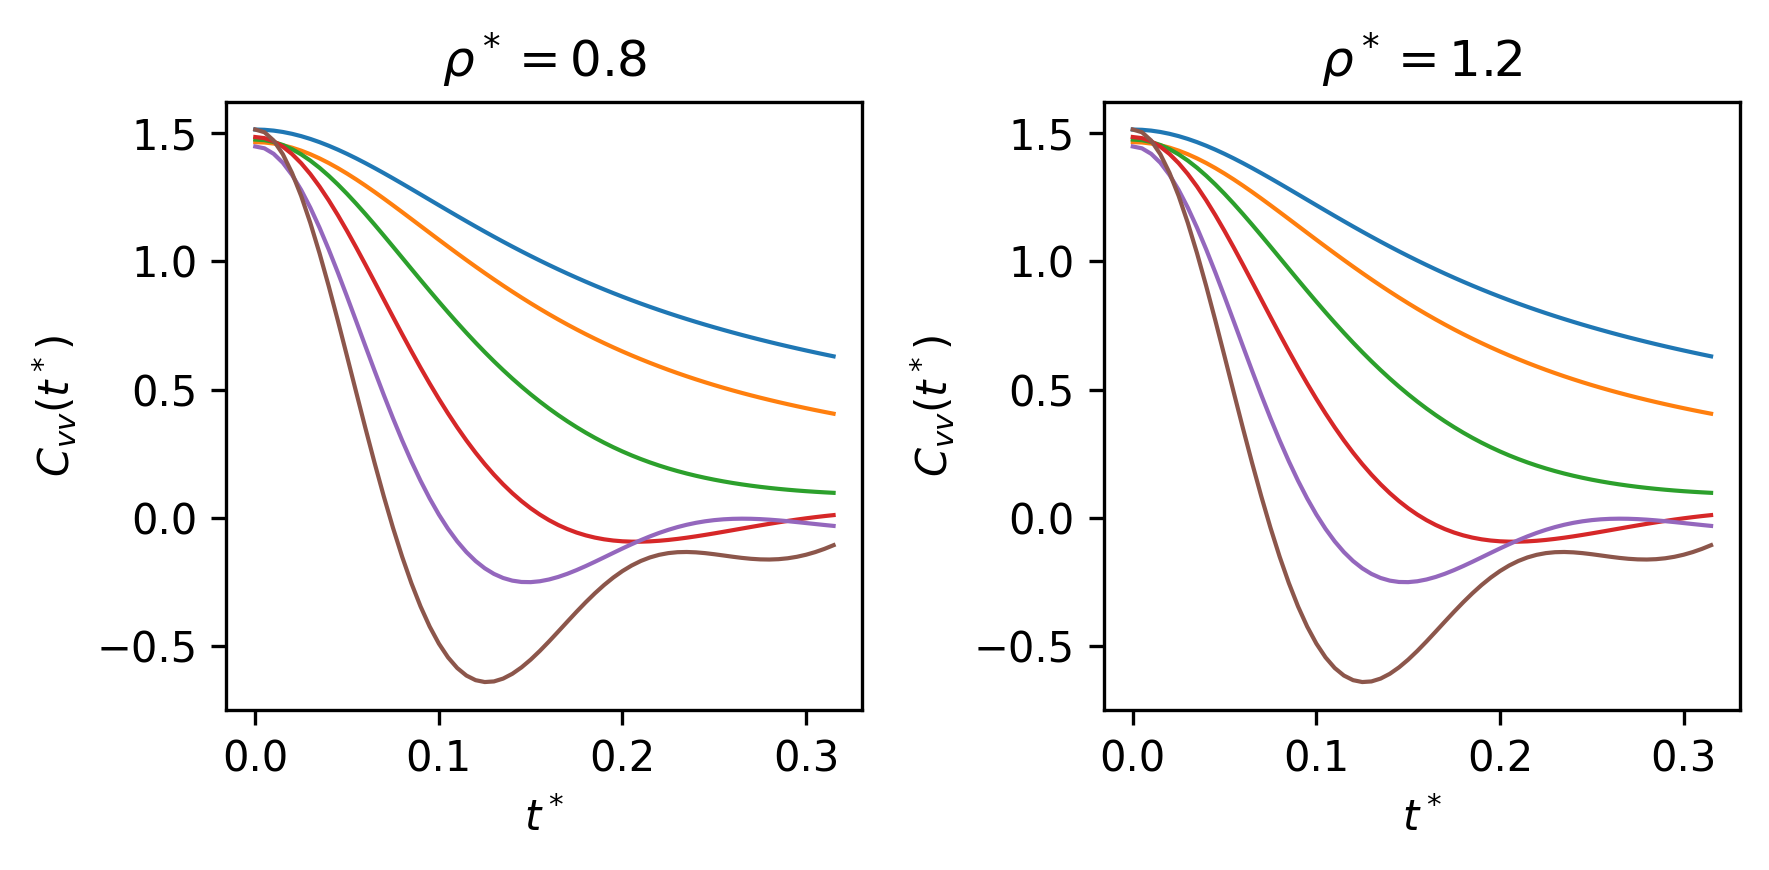

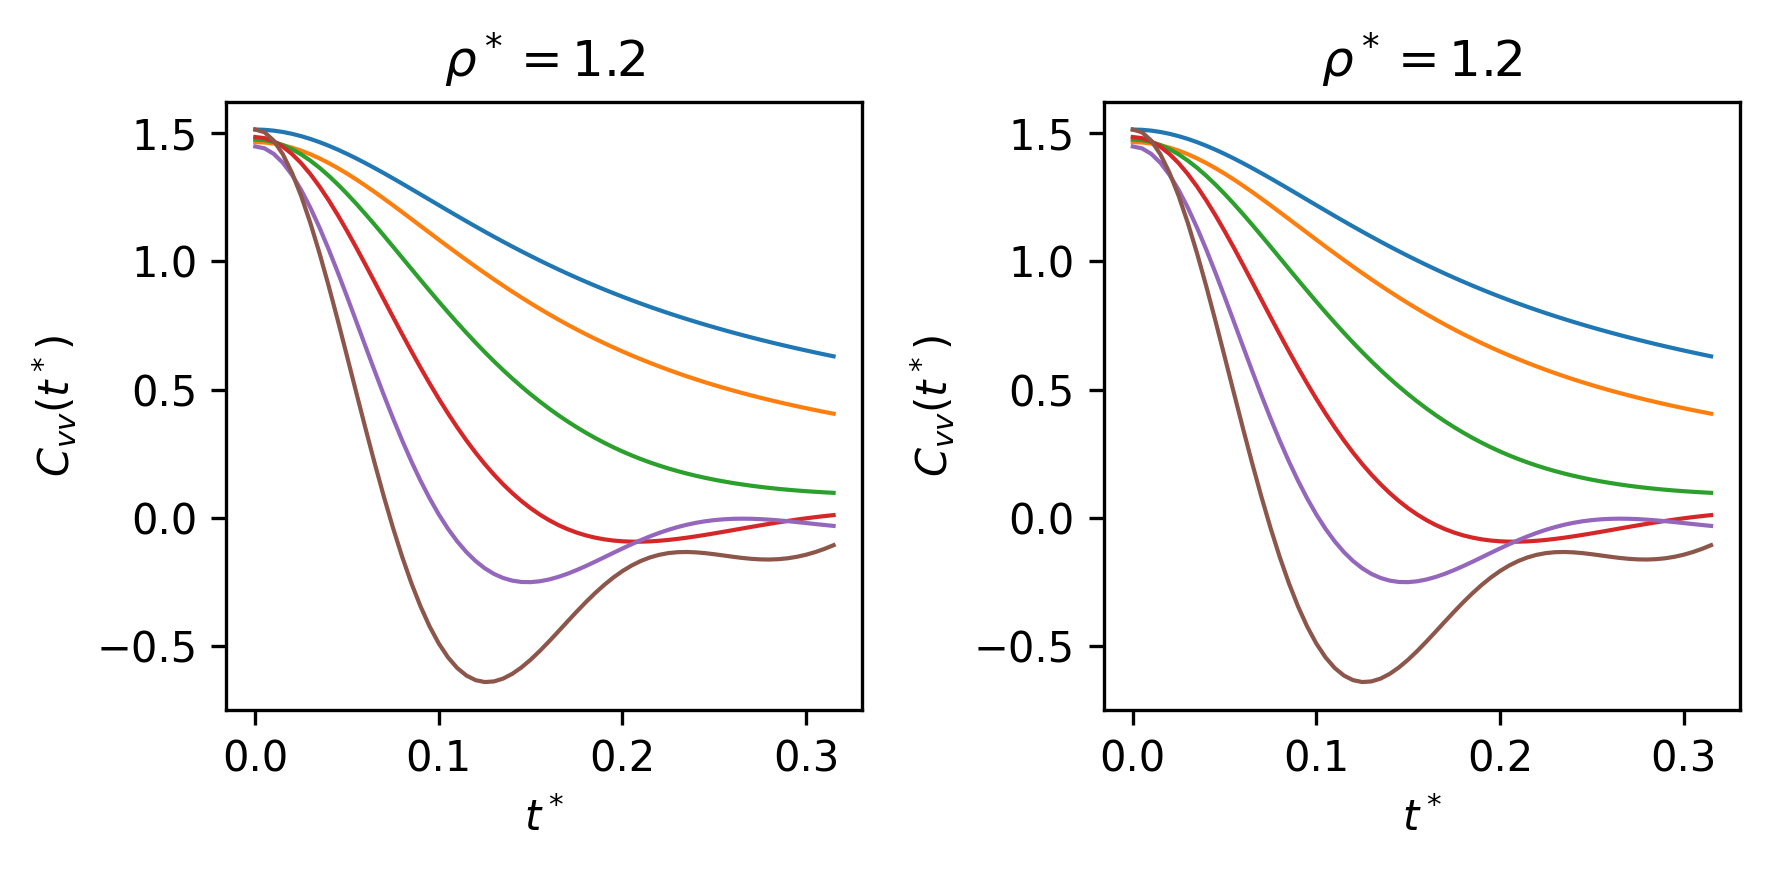

In [ ]:
for istate in range(nstate):
    fig, axes = plt.subplots(figsize=(6, 3), dpi=300, ncols=2, nrows=1)

    for iax, xax in enumerate(axes):
        xax.set_title(r"$\rho^*=$" + f"{rhos[istate]}")
        xax.set_xlabel(r"$t^*$")
        xax.set_ylabel(r"$C_{vv}(t^*)$")
        for istate in range(nstate):
            for level in range(levelmax):
                xax.plot(
                    vcorrav_dict[istate][:, 2 * level],
                    vcorrav_dict[istate][:, 2 * level + 1],
                    lw=1.0,
                )  # Add lines with different data structure names for each run here
                fig.tight_layout()

## (4.5) Plot out density dependence of quantities

In [ ]:
fig, axes = plt.subplots(figsize=(6, 6), dpi=300, ncols=1, nrows=2)
for iax, xax in enumerate(axes):

    if iax == 0:
        xax.set_xlabel(r"$\rho^*$")
        xax.set_ylabel(r"$D*$")
        xax.set_title(r"$D^*_{vv}$ (blue),$D^*_{R2}$ (red)")

        for istate in range(nstate):

            xax.scatter(
                av_dict[istate][0], av_dict[istate][1], c="b", label=r"$D^*_{vv}$"
            )
            xax.scatter(
                av_dict[istate][0], av_dict[istate][2], c="r", label=r"$D^*_{R2}$"
            )

    elif iax == 1:

        xax.set_xlabel(r"$\rho^*$")
        xax.set_ylabel(r"$Energy*/N$")
        xax.set_title(r"$<PE>/N$ (red),$<KE>/N$ (green),$<Etot>/N$ (blue)")
        for istate in range(nstate):

            xax.scatter(av_dict[istate][0], av_dict[istate][3], c="r", label=r"$<V>/N$")
            xax.scatter(av_dict[istate][0], av_dict[istate][4], c="g", label=r"$<K>/N$")
            xax.scatter(av_dict[istate][0], av_dict[istate][5], c="b", label=r"$<E>/N$")

fig.tight_layout()

## (4.6) Make frequency and complex exponential arrays for Fourier transformations

In [ ]:
@njit
def make_frequencies():
    pi = 3.14159265
    eye = 0.0 + 1.0j

    dtc = ncorr * dt
    tcmax = ncorrtot * dtc
    dfreq = 2.0 * pi / tcmax

    freq = np.zeros(ncorrtot)

    epiwdt = np.zeros(ncorrtot, dtype=np.complex128)
    emiwdt = np.zeros(ncorrtot, dtype=np.complex128)

    for i in range(ncorrtot):
        freq[i] = float(i) * dfreq
        epiwdt[i] = c.exp(eye * freq[i] * dtc)
        emiwdt[i] = c.exp(-eye * freq[i] * dtc)

    return freq, epiwdt, emiwdt, dtc, dfreq, pi, eye

## (4.7) Perform cosine transform of VAC data and plot DOS data at various state points

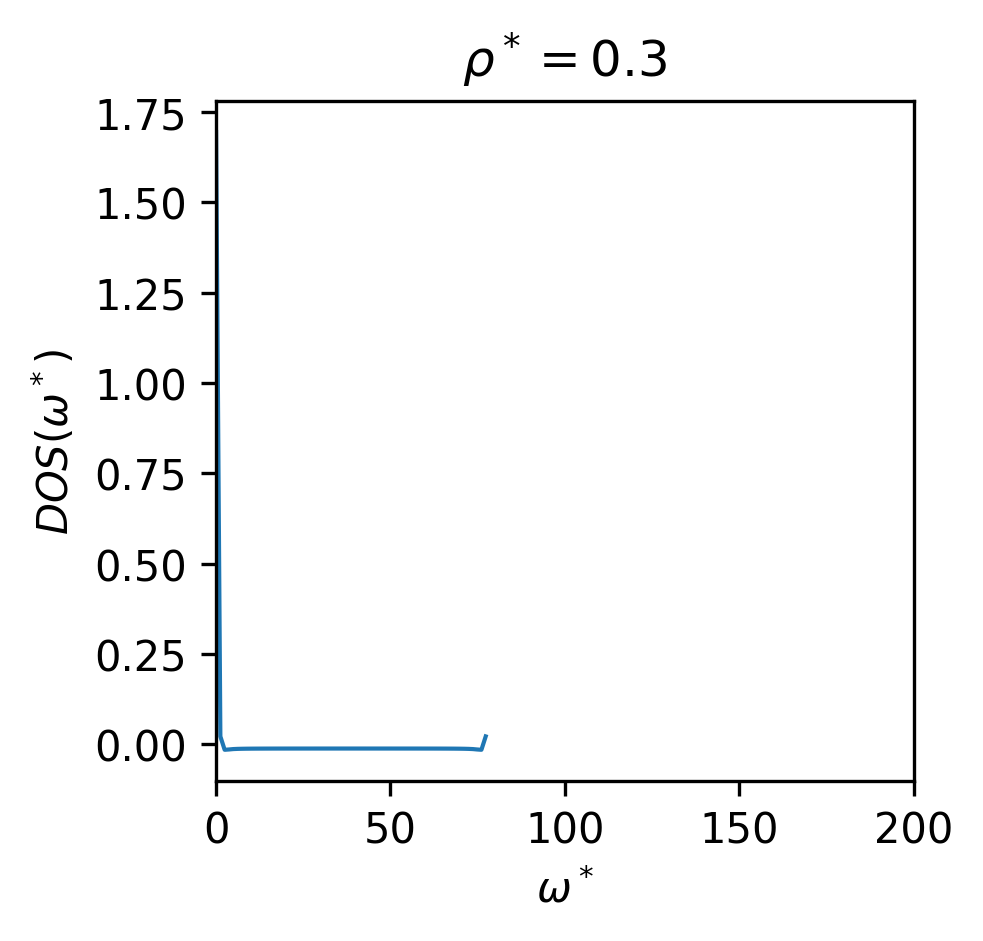

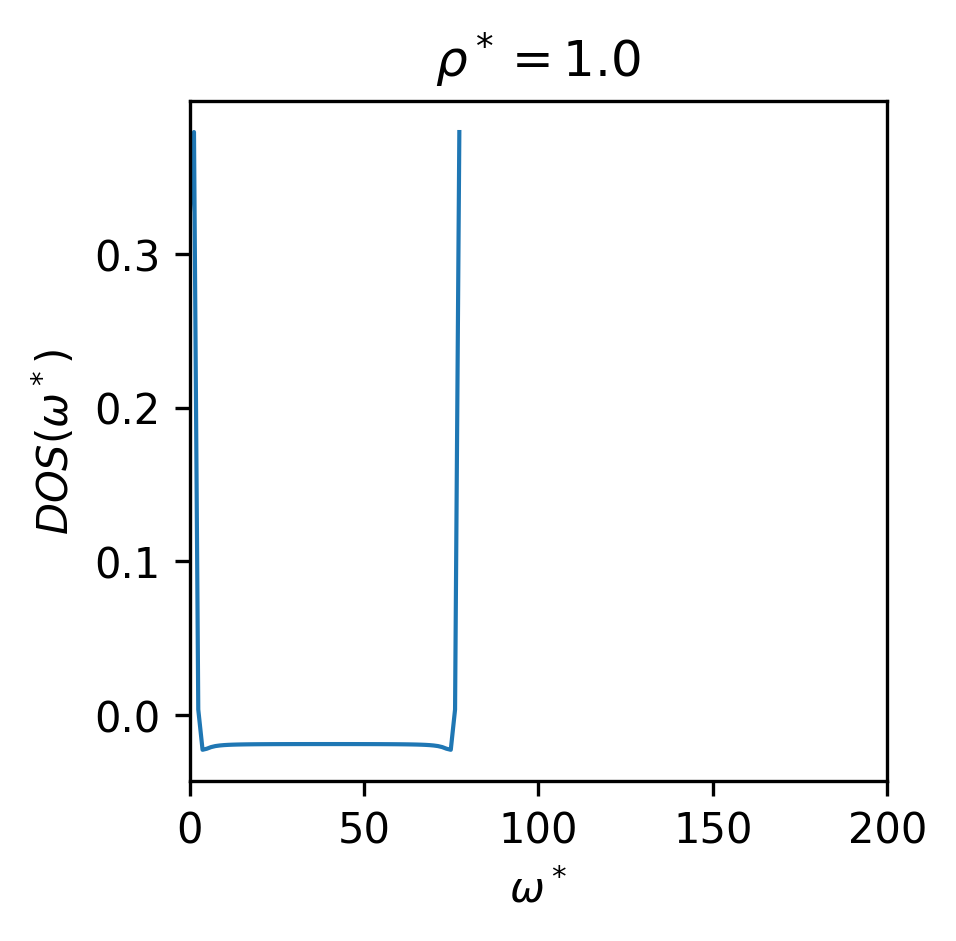

In [ ]:
freq, epiwdt, emiwdt, dtc, dfreq, pi, eye = make_frequencies()
for istate in range(nstate):

    dos = np.zeros(ncorrtot, dtype=np.complex128)
    v_corr = vcorrav_dict[istate]
    ept = 1.0 + 0.0j
    emt = 1.0 + 0.0j
    cosfac = 0.5 * (ept + emt)
    ctrans = np.zeros(ncorrtot, dtype=np.complex128)
    for ifreq in range(ncorrtot):
        for ntime in range(ncorrtot):
            ept *= epiwdt[ifreq]
            emt *= emiwdt[ifreq]
            cosfac = 0.5 * (ept + emt)
            ctrans[ifreq] += cosfac * v_corr[ntime, 1]
    ctrans = ctrans * dtc
    dos = ctrans / pi

    fig, axes = plt.subplots(figsize=(3, 3), dpi=300, ncols=1, nrows=1)
    axes.set_title(r"$\rho^*=$" + f"{rhos[istate]}")
    axes.set_xlabel(r"$\omega^*$")
    axes.set_ylabel(r"$DOS(\omega^*)$")
    axes.set_xlim((0, 200))
    axes.plot(freq, dos.real, lw=1.0)
fig.tight_layout()